Welcome mate

Here we’ll build and train several models for *forecasting* the power generated by solar panels  
You’ll walk through the full process from preprocessing and sequence creation to model design, training, and evaluation

follow along

In [1]:
'''import sys
import pandas as pd
import numpy as np
import joblib

# Create compatibility classes for old pandas
class Int64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='int64', copy=copy, name=name)

class Float64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='float64', copy=copy, name=name)

class UInt64Index(pd.Index):
    def __new__(cls, data=None, dtype=None, copy=False, name=None):
        return pd.Index(data, dtype='uint64', copy=copy, name=name)

# Create a dummy module with these classes
class NumericIndexModule:
    Int64Index = Int64Index
    Float64Index = Float64Index
    UInt64Index = UInt64Index
    RangeIndex = pd.RangeIndex

# Patch the missing module
sys.modules['pandas.core.indexes.numeric'] = NumericIndexModule()

# Also patch other potential old modules
class DatetimeIndexModule:
    DatetimeIndex = pd.DatetimeIndex

class TimedeltaIndexModule:
    TimedeltaIndex = pd.TimedeltaIndex

sys.modules['pandas.core.indexes.datetimes'] = DatetimeIndexModule()
sys.modules['pandas.core.indexes.timedeltas'] = TimedeltaIndexModule()

# Now try loading
try:
    df = joblib.load('Data/df5.pkl')
    print(f" SUCCESS!")
    print(f"Type: {type(df)}")
    print(f"Shape: {df.shape}")
    print(f"\nFirst 10 rows:")
    print(df.head(10))
    print(f"\nColumn names:")
    print(df.columns.tolist())
    print(f"\nDataFrame Info:")
    df.info()
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()'''

'import sys\nimport pandas as pd\nimport numpy as np\nimport joblib\n\n# Create compatibility classes for old pandas\nclass Int64Index(pd.Index):\n    def __new__(cls, data=None, dtype=None, copy=False, name=None):\n        return pd.Index(data, dtype=\'int64\', copy=copy, name=name)\n\nclass Float64Index(pd.Index):\n    def __new__(cls, data=None, dtype=None, copy=False, name=None):\n        return pd.Index(data, dtype=\'float64\', copy=copy, name=name)\n\nclass UInt64Index(pd.Index):\n    def __new__(cls, data=None, dtype=None, copy=False, name=None):\n        return pd.Index(data, dtype=\'uint64\', copy=copy, name=name)\n\n# Create a dummy module with these classes\nclass NumericIndexModule:\n    Int64Index = Int64Index\n    Float64Index = Float64Index\n    UInt64Index = UInt64Index\n    RangeIndex = pd.RangeIndex\n\n# Patch the missing module\nsys.modules[\'pandas.core.indexes.numeric\'] = NumericIndexModule()\n\n# Also patch other potential old modules\nclass DatetimeIndexModule:\

^^^ this to deal w old pandas pkl files 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

# read pkl files 

In [3]:
files = [
    "df1_new.pkl",
    "df2_new.pkl",
    "df3_new.pkl",
    "df4_new.pkl",
    "df5_new.pkl"
]
dfs_raw = [pd.read_pickle("Data/" + f) for f in files]


# Verify Time Consistency

First, check if all datasets follow the same time frequency (e.g., every second or every minute).
If they’re not perfectly aligned or have missing timestamps, resample them to a unified scale using:

In [4]:
for df in dfs_raw:
    df['Time'] = pd.to_datetime(df['Time'])
    diffs = df['Time'].diff().dropna()
    print(diffs.value_counts().head())

Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64
Time
0 days 00:01:00    525136
0 days 00:00:00      2933
0 days 00:02:00         4
0 days 00:19:00         2
0 days 00:09:00         2
Name: count, dtype: int64


525136 sample recorde in every minute   

2933 duplicates sample in ech file

# Resample to 1min

In [5]:
for df in dfs_raw:
    print(df.head(10))

                 Time  Total Solar Irradiance on Inclined Plane POA1 (W/m2)  \
0 2020-01-01 00:01:00                                                0.0      
1 2020-01-01 00:02:00                                                0.0      
2 2020-01-01 00:03:00                                                0.0      
3 2020-01-01 00:04:00                                                0.0      
4 2020-01-01 00:05:00                                                0.0      
5 2020-01-01 00:06:00                                                0.0      
6 2020-01-01 00:07:00                                                0.0      
7 2020-01-01 00:08:00                                                0.0      
8 2020-01-01 00:09:00                                                0.0      
9 2020-01-01 00:10:00                                                0.0      

   Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)  \
0                                        5469.738281       
1         

In [6]:

def resample_sanity_check(df, freq="1min"):
    df = df.copy()

    print(">>> Before")
    print("shape:", df.shape)


    # 1) parse time
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce', utc=False)
    bad_ts = df['Time'].isna().sum()
    print("bad timestamps:", bad_ts)

    # drop rows with invalid time
    df = df.dropna(subset=['Time']).set_index('Time').sort_index()

    # 2) show original index info
    print("\n>>> Original index")
    print("range:", df.index.min(), "→", df.index.max())
    print("is_monotonic:", df.index.is_monotonic_increasing)
    print("duplicate timestamps:", int(df.index.duplicated().sum()))
    
    # 3) keep numeric columns only (resample().mean() ignores non-numeric)
    num_cols = df.select_dtypes(include='number').columns
    df = df[num_cols]
    print("\nkept numeric columns:", len(num_cols))

    # if duplicates exist, collapse them with mean at same timestamp
    if df.index.duplicated().any():
        df = df.groupby(level=0).mean()

    # 4) resample
    out = df.resample(freq).mean()

    # 5) prints after resample
    print("\n>>> After resample")
    print("shape:", out.shape, "| freq:", freq)
    print("range:", out.index.min(), "→", out.index.max())
    # 6) quick gap/delta check
    deltas = out.index.to_series().diff().dropna()
    print("\nTop index deltas (counts):")
    print(deltas.value_counts().head())

    # 7) missingness snapshot
    na_pct = (out.isna().mean()*100).round(2)
    print("\n% Missing per column (top 10):")
    print(na_pct.sort_values(ascending=False).head(10))
    print("\n\n")

    return out

In [7]:
dfs_resampled = [resample_sanity_check(df, freq="1min") for df in dfs_raw]

>>> Before
shape: (528097, 23)
bad timestamps: 0

>>> Original index
range: 2020-01-01 00:01:00 → 2020-12-31 23:59:00
is_monotonic: True
duplicate timestamps: 2933

kept numeric columns: 22

>>> After resample
shape: (527039, 22) | freq: 1min
range: 2020-01-01 00:01:00 → 2020-12-31 23:59:00

Top index deltas (counts):
Time
0 days 00:01:00    527038
Name: count, dtype: int64

% Missing per column (top 10):
Isc Ref\n(Amp)                                            0.74
Isc Test\n(Amp)                                           0.74
Temperature \nReference Cell\n(Deg C)                     0.74
Geff Test\n(W/M2)                                         0.74
Geff Reference\n(W/M2)                                    0.74
Temperature \nTest\n(Deg C)                               0.74
Soiling Loss Index Geff (%)                               0.74
Control-PPC - Active power (1m)                           0.63
Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)    0.55
Total Solar Irradiance o

new shape >> shape: (527039, 22) | freq: 1min


# Standardize Column Names

In [8]:
for df in dfs_raw: print(df.columns.tolist())

['Time', 'Total Solar Irradiance on Inclined Plane POA1 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA1 (Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (W/m2)', 'Total Solar Irradiance on Inclined Plane POA2 (Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI (Wh/m2)', 'Ambient Temp. (degree centigrade)', 'Module Surface Temperature1 (degree centigrade)', 'Module Surface Temperature2 (degree centigrade)', 'Wind Speed(m/s)', 'Wind direction(degree)', 'Daily rain (mm)', 'Relative Humidity (%)', 'Soiling Loss Index\nIsc\n(%) ', 'Soiling Loss Index Geff (%)', 'Isc Test\n(Amp)', 'Isc Ref\n(Amp)', 'Temperature \nTest\n(Deg C)', 'Temperature \nReference Cell\n(Deg C)', 'Geff Test\n(W/M2)', 'Geff Reference\n(W/M2)', 'Control-PPC - Active power (1m)']
['Time', 'Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(

In [9]:
def normalize_cols(df):
    df.columns = (
        df.columns
        .str.replace(r'\.\d+$', '', regex=True)        # remove .1, .2, etc.
        .str.replace('\n', ' ', regex=False)           # remove line breaks
        .str.replace(r'\s+\(', '(', regex=True)        # remove space before '('
        .str.replace(r'\s+', ' ', regex=True)          # collapse multiple spaces
        .str.strip()                                   # trim start/end spaces
    )
    return df


In [10]:
dfs_resampled = [normalize_cols(df) for df in dfs_resampled]

In [11]:
for i, df in enumerate(dfs_resampled, start=1):
    print(f"File{i} columns hash:", hash(tuple(df.columns)))


File1 columns hash: -348576595061816693
File2 columns hash: -348576595061816693
File3 columns hash: -348576595061816693
File4 columns hash: -348576595061816693
File5 columns hash: -348576595061816693


now we have same columns name in all files

In [12]:
for df in dfs_resampled:
    print(df.shape)
    print(df.columns.tolist())

(527039, 22)
['Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)', 'Total Solar Irradiance on Inclined Plane POA2(Wh/m2)', 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)', 'Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)', 'Ambient Temp.(degree centigrade)', 'Module Surface Temperature1(degree centigrade)', 'Module Surface Temperature2(degree centigrade)', 'Wind Speed(m/s)', 'Wind direction(degree)', 'Daily rain(mm)', 'Relative Humidity(%)', 'Soiling Loss Index Isc(%)', 'Soiling Loss Index Geff(%)', 'Isc Test(Amp)', 'Isc Ref(Amp)', 'Temperature Test(Deg C)', 'Temperature Reference Cell(Deg C)', 'Geff Test(W/M2)', 'Geff Reference(W/M2)', 'Control-PPC - Active power(1m)']
(527039, 22)
['Total Solar Irradiance on Inclined Plane POA1(W/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)', 'Total Solar Ir

In [13]:
df_main = dfs_resampled[0] 

# handle outliers

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/3306031107.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')


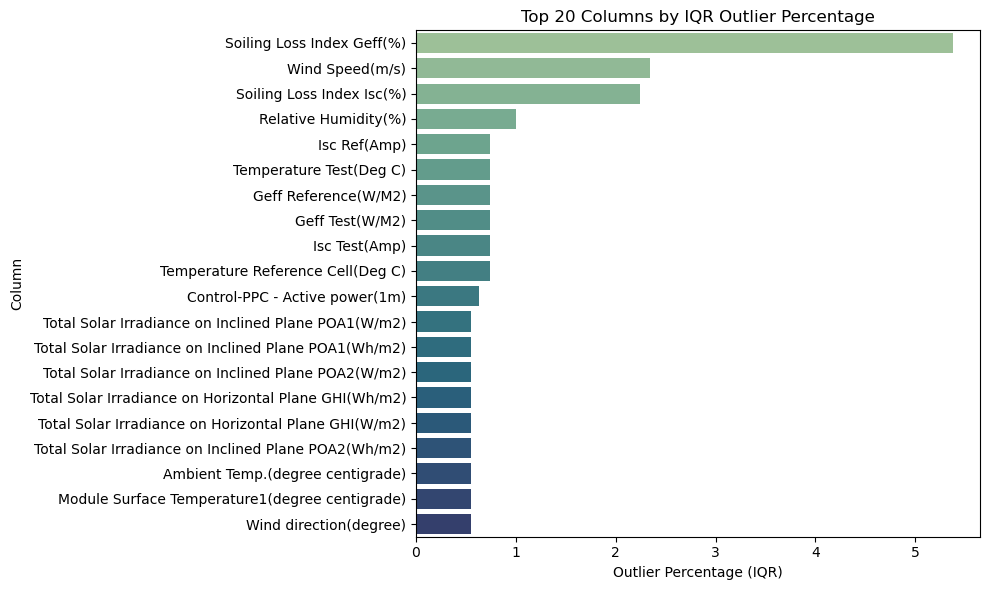

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/3306031107.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')


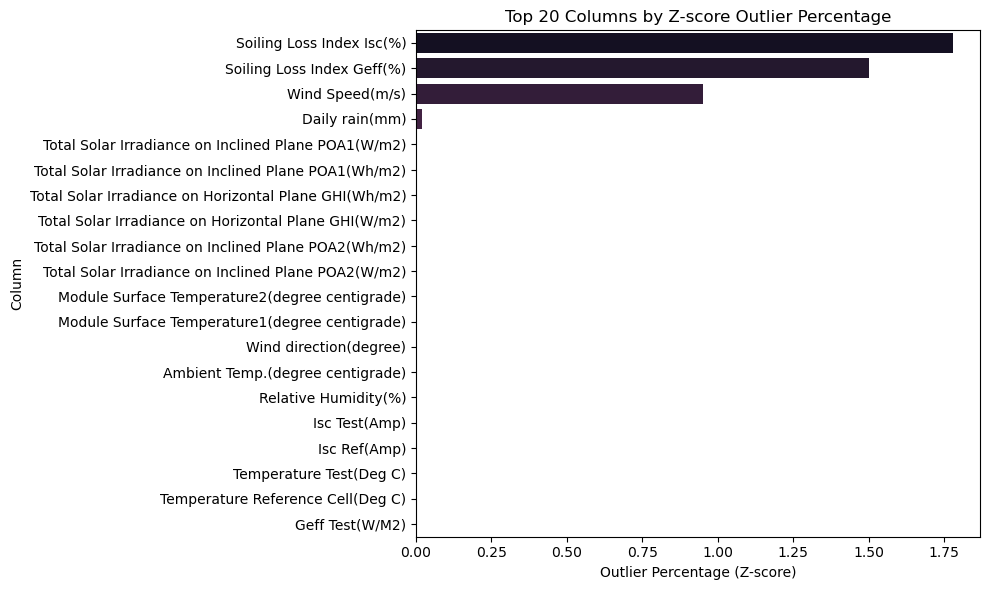

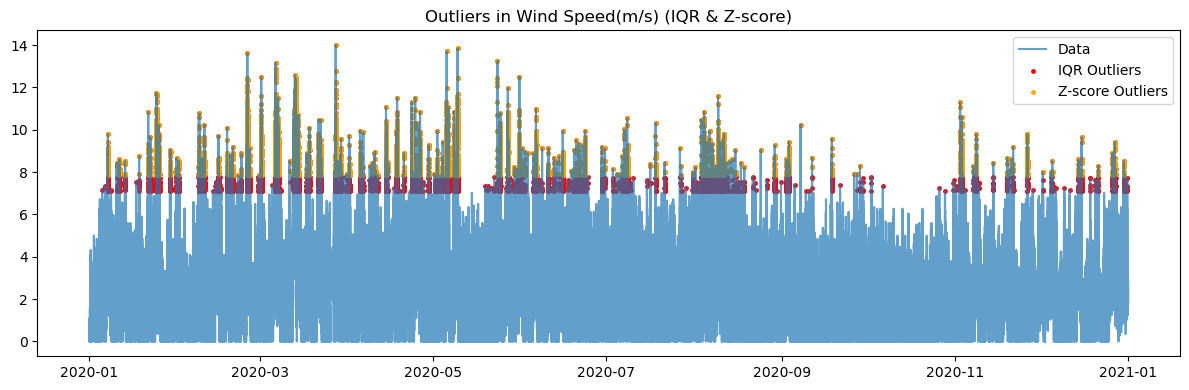

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- outlier detectors
def detect_outliers_iqr(series, factor=1.5):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = valid.quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=series.index)
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = ~series.between(lower, upper, inclusive='both')
    return mask.fillna(False)

def detect_outliers_zscore(series, threshold=3.0):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    mean = valid.mean()
    std = valid.std(ddof=0)
    if pd.isna(std) or std == 0:
        return pd.Series(False, index=series.index)
    z = (series - mean) / std
    mask = z.abs() > threshold
    return mask.fillna(False)

# --- choose numeric columns, exclude helper flags
numeric_df = df_main.filter(regex=r'^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- per-column counts
outlier_rows = []
for col in numeric_df.columns:                      # iterate columns explicitly
    s = df_main[col]
    m_iqr = detect_outliers_iqr(s)
    m_z   = detect_outliers_zscore(s)
    outlier_rows.append({
        'column': col,
        'iqr_count': int(m_iqr.sum()),
        'z_count':   int(m_z.sum()),
        'iqr_pct':   round(m_iqr.mean() * 100, 2),
        'z_pct':     round(m_z.mean()   * 100, 2),
    })

outlier_df = pd.DataFrame(outlier_rows).set_index('column')

# --- top by IQR %
top_iqr = outlier_df.sort_values('iqr_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')
plt.title('Top 20 Columns by IQR Outlier Percentage')
plt.xlabel('Outlier Percentage (IQR)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- top by Z-score %
top_z = outlier_df.sort_values('z_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')
plt.title('Top 20 Columns by Z-score Outlier Percentage')
plt.xlabel('Outlier Percentage (Z-score)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- point-level visualization for a single column
col = 'Wind Speed(m/s)'   # change as needed
s = df_main[col]
m_iqr = detect_outliers_iqr(s)
m_z   = detect_outliers_zscore(s)

plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label='Data', alpha=0.7)
plt.scatter(s.index[m_iqr], s[m_iqr], color='red',    s=6, label='IQR Outliers')
plt.scatter(s.index[m_z],   s[m_z],   color='orange', s=6, label='Z-score Outliers')
plt.title(f'Outliers in {col} (IQR & Z-score)')
plt.legend()
plt.tight_layout()
plt.show()


### Mark and replace outliers with NaN

In [15]:
nan_counts = df_main.isna().sum()
print(nan_counts)

Total Solar Irradiance on Inclined Plane POA1(W/m2)      2878
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)     2878
Total Solar Irradiance on Inclined Plane POA2(W/m2)      2878
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)     2878
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     2878
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)    2878
Ambient Temp.(degree centigrade)                         2878
Module Surface Temperature1(degree centigrade)           2878
Module Surface Temperature2(degree centigrade)           2878
Wind Speed(m/s)                                          2878
Wind direction(degree)                                   2878
Daily rain(mm)                                           2878
Relative Humidity(%)                                     2878
Soiling Loss Index Isc(%)                                2437
Soiling Loss Index Geff(%)                               3877
Isc Test(Amp)                                            3877
Isc Ref(

In [16]:
for col in df_main.select_dtypes('number'):
    mask = detect_outliers_iqr(df_main[col])  
    df_main.loc[mask, col] = np.nan
#main df

In [17]:
for df in dfs_resampled[1:]:
    for col in df.select_dtypes('number'):
        mask = detect_outliers_iqr(df[col])  
        df.loc[mask, col] = np.nan

In [18]:
nan_counts = df_main.isna().sum()
print(nan_counts)

Total Solar Irradiance on Inclined Plane POA1(W/m2)       2878
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)      2878
Total Solar Irradiance on Inclined Plane POA2(W/m2)       2878
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)      2878
Total Solar Irradiance on Horizontal Plane GHI(W/m2)      2880
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)     2878
Ambient Temp.(degree centigrade)                          2881
Module Surface Temperature1(degree centigrade)            2878
Module Surface Temperature2(degree centigrade)            2878
Wind Speed(m/s)                                          12320
Wind direction(degree)                                    2878
Daily rain(mm)                                            2878
Relative Humidity(%)                                      5279
Soiling Loss Index Isc(%)                                11793
Soiling Loss Index Geff(%)                               28370
Isc Test(Amp)                                          

In [19]:
nan_countss= dfs_resampled[1].isna().sum()
print(nan_countss)

Total Solar Irradiance on Inclined Plane POA1(W/m2)       4256
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)      4256
Total Solar Irradiance on Inclined Plane POA2(W/m2)       4256
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)      4256
Total Solar Irradiance on Horizontal Plane GHI(W/m2)      4258
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)     4256
Ambient Temp.(degree centigrade)                          4256
Module Surface Temperature1(degree centigrade)            4256
Module Surface Temperature2(degree centigrade)            4256
Wind Speed(m/s)                                          15967
Wind direction(degree)                                    4256
Daily rain(mm)                                            4256
Relative Humidity(%)                                      6796
Soiling Loss Index Isc(%)                                20500
Soiling Loss Index Geff(%)                               11860
Isc Test(Amp)                                          

**Handle Missing Values**

If datasets represent the same sensor/location, and the correlation is high (>0.95) → use one dataset to fill missing values in another at the same timestamp.

If the correlation is low or unstable, use temporal methods instead:
ffill, bfill, or time-based interpolation.

Why:
Forward/backward filling preserves the time order — crucial for forecasting — while cross-filling leverages sensor redundancy safely.


# Handling Missing Values Across Sensor Files

Since all sensor datasets represent the same physical system and share similar patterns, missing values are handled using a correlation-driven strategy:

Cross-Filling (when correlation > 0.95):
If two sensors show a very high correlation, missing values in one dataset are filled using the corresponding values from another sensor at the same timestamps.
This leverages redundancy between sensors and preserves real physical behavior.

Temporal Filling (when correlation < 0.95):
For sensors with lower or unstable correlation, missing values are filled using time-based methods — ffill, bfill, or interpolate(method='time').
This ensures temporal continuity without distorting the signal.

Smoothing (optional):
A light rolling median can be applied afterward to smooth small spikes or interpolation noise.

This approach combines cross-sensor reliability with time-series consistency, ensuring that the filled data remains both realistic and forecasting-friendly.

In [20]:
# --- Step 3: Handle Missing Values (Simple + Practical) ---

# 2) use cross-filling if other files have similar structure
for df in dfs_resampled[1:]:
    # align timestamps
    df = df.reindex(df_main.index)
    # fill only where df_main has NaN and donor has data
    for col in df_main.columns.intersection(df.columns):
        mask = df_main[col].isna() & df[col].notna()
        df_main.loc[mask, col] = df.loc[mask, col]

# 3) fill remaining gaps using time-based interpolation + fallback
df_main = (
    df_main.interpolate(method='time', limit_direction='both')
            .ffill()
            .bfill()
)

# 4) quick check
missing_after = df_main.isna().mean() * 100
print("Remaining missing percentage per column:\n", missing_after.sort_values(ascending=False))



Remaining missing percentage per column:
 Total Solar Irradiance on Inclined Plane POA1(W/m2)      0.0
Total Solar Irradiance on Inclined Plane POA1(Wh/m2)     0.0
Total Solar Irradiance on Inclined Plane POA2(W/m2)      0.0
Total Solar Irradiance on Inclined Plane POA2(Wh/m2)     0.0
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     0.0
Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)    0.0
Ambient Temp.(degree centigrade)                         0.0
Module Surface Temperature1(degree centigrade)           0.0
Module Surface Temperature2(degree centigrade)           0.0
Wind Speed(m/s)                                          0.0
Wind direction(degree)                                   0.0
Daily rain(mm)                                           0.0
Relative Humidity(%)                                     0.0
Soiling Loss Index Isc(%)                                0.0
Soiling Loss Index Geff(%)                               0.0
Isc Test(Amp)                              

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/584655106.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')


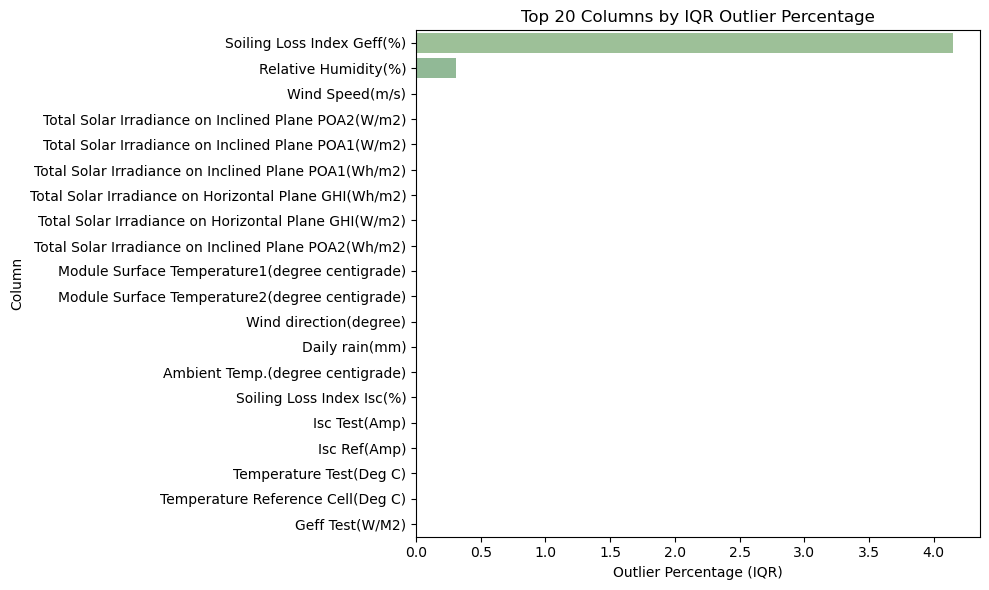

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/584655106.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')


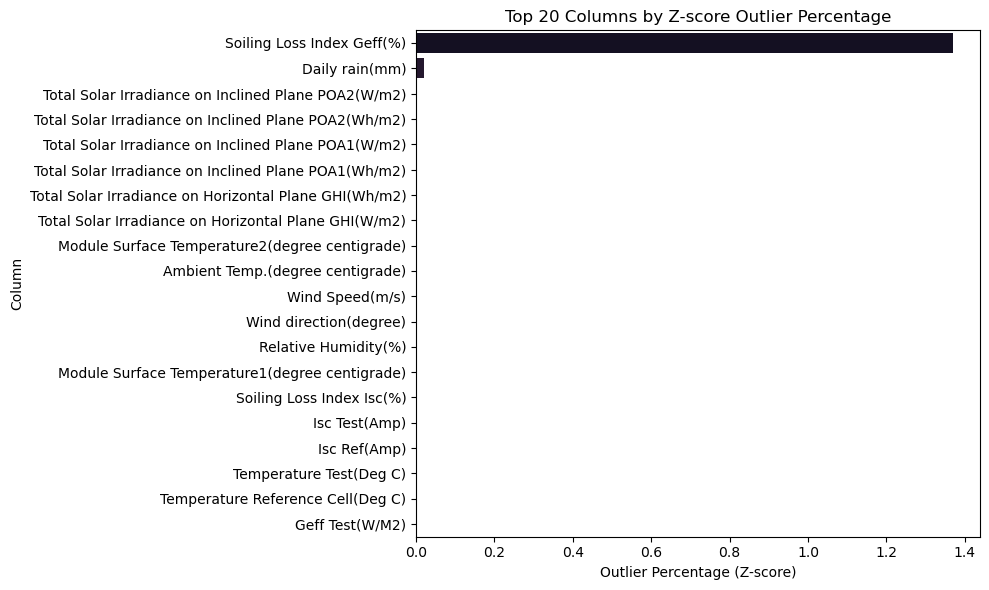

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- outlier detectors
def detect_outliers_iqr(series, factor=1.5):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    q1, q3 = valid.quantile([0.25, 0.75])
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return pd.Series(False, index=series.index)
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = ~series.between(lower, upper, inclusive='both')
    return mask.fillna(False)

def detect_outliers_zscore(series, threshold=3.0):
    valid = series.dropna()
    if valid.empty:
        return pd.Series(False, index=series.index)
    mean = valid.mean()
    std = valid.std(ddof=0)
    if pd.isna(std) or std == 0:
        return pd.Series(False, index=series.index)
    z = (series - mean) / std
    mask = z.abs() > threshold
    return mask.fillna(False)

# --- choose numeric columns, exclude helper flags
numeric_df = df_main.filter(regex=r'^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- per-column counts
outlier_rows = []
for col in numeric_df.columns:                      # iterate columns explicitly
    s = df_main[col]
    m_iqr = detect_outliers_iqr(s)
    m_z   = detect_outliers_zscore(s)
    outlier_rows.append({
        'column': col,
        'iqr_count': int(m_iqr.sum()),
        'z_count':   int(m_z.sum()),
        'iqr_pct':   round(m_iqr.mean() * 100, 2),
        'z_pct':     round(m_z.mean()   * 100, 2),
    })

outlier_df = pd.DataFrame(outlier_rows).set_index('column')

# --- top by IQR %
top_iqr = outlier_df.sort_values('iqr_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_iqr, x='iqr_pct', y='column', orient='h', palette='crest')
plt.title('Top 20 Columns by IQR Outlier Percentage')
plt.xlabel('Outlier Percentage (IQR)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()

# --- top by Z-score %
top_z = outlier_df.sort_values('z_pct', ascending=False).head(20).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_z, x='z_pct', y='column', orient='h', palette='rocket')
plt.title('Top 20 Columns by Z-score Outlier Percentage')
plt.xlabel('Outlier Percentage (Z-score)')
plt.ylabel('Column')
plt.tight_layout()
plt.show()




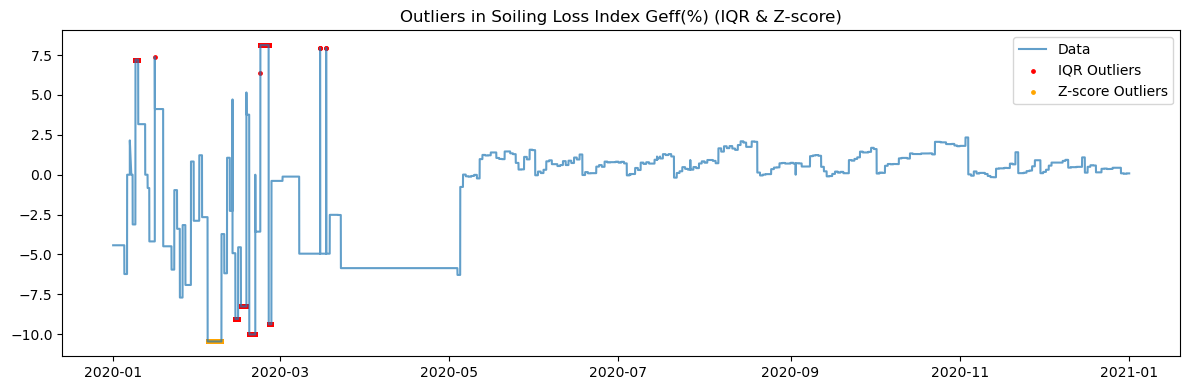

In [22]:
# --- point-level visualization for a single column
col = 'Soiling Loss Index Geff(%)'   # change as needed
s = df_main[col]
m_iqr = detect_outliers_iqr(s)
m_z   = detect_outliers_zscore(s)

plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label='Data', alpha=0.7)
plt.scatter(s.index[m_iqr], s[m_iqr], color='red',    s=6, label='IQR Outliers')
plt.scatter(s.index[m_z],   s[m_z],   color='orange', s=6, label='Z-score Outliers')
plt.title(f'Outliers in {col} (IQR & Z-score)')
plt.legend()
plt.tight_layout()
plt.show()


# computes the correlation

In [23]:
#rename the target column
df_main = df_main.rename(columns={'Control-PPC - Active power(1m)': 'active_power'})

Top correlations with active_power:

active_power                                             1.000000
Total Solar Irradiance on Inclined Plane POA1(W/m2)      0.985811
Total Solar Irradiance on Inclined Plane POA2(W/m2)      0.985355
Isc Test(Amp)                                            0.982002
Isc Ref(Amp)                                             0.981853
Total Solar Irradiance on Horizontal Plane GHI(W/m2)     0.949913
Geff Test(W/M2)                                          0.836756
Geff Reference(W/M2)                                     0.829262
Module Surface Temperature2(degree centigrade)           0.827909
Module Surface Temperature1(degree centigrade)           0.823684
Temperature Reference Cell(Deg C)                        0.819388
Temperature Test(Deg C)                                  0.814757
Ambient Temp.(degree centigrade)                         0.430380
Wind Speed(m/s)                                          0.389136
Wind direction(degree)                 

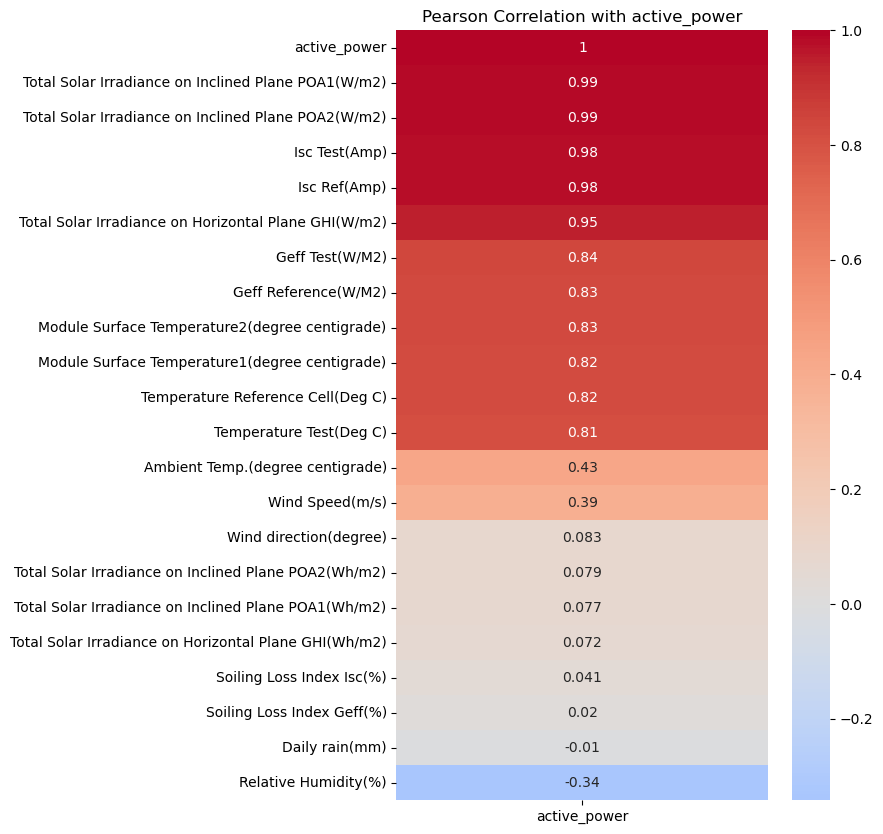

In [24]:

# --- drop non-numeric columns (just in case)
num_df = df_main.filter(regex='^(?!.*(_was_na|_outlier))').select_dtypes('number')

# --- compute Pearson correlations
corr = num_df.corr()['active_power'].sort_values(ascending=False)

# --- display top correlations
print("Top correlations with active_power:\n")
print(corr)

# --- visualize as heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.title("Pearson Correlation with active_power")
plt.show()


In [25]:
num_df = df_main.filter(regex='^(?!.*(_was_na|_outlier))').select_dtypes('number')
corr = num_df.corr()['active_power'].drop('active_power')

# sort by absolute correlation (|r|)
corr_sorted = corr.abs().sort_values()

# show the weakest correlations (closest to 0)
weakest = corr_sorted.head(20).index.tolist()
print("Columns with weakest correlation to active_power:\n", weakest)

# optional: view their actual r values (signed)
print("\nActual correlation values for these columns:\n")
print(corr.loc[weakest])



Columns with weakest correlation to active_power:
 ['Daily rain(mm)', 'Soiling Loss Index Geff(%)', 'Soiling Loss Index Isc(%)', 'Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA1(Wh/m2)', 'Total Solar Irradiance on Inclined Plane POA2(Wh/m2)', 'Wind direction(degree)', 'Relative Humidity(%)', 'Wind Speed(m/s)', 'Ambient Temp.(degree centigrade)', 'Temperature Test(Deg C)', 'Temperature Reference Cell(Deg C)', 'Module Surface Temperature1(degree centigrade)', 'Module Surface Temperature2(degree centigrade)', 'Geff Reference(W/M2)', 'Geff Test(W/M2)', 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)', 'Isc Ref(Amp)', 'Isc Test(Amp)', 'Total Solar Irradiance on Inclined Plane POA2(W/m2)']

Actual correlation values for these columns:

Daily rain(mm)                                          -0.010111
Soiling Loss Index Geff(%)                               0.019661
Soiling Loss Index Isc(%)                                0.041089
T

                                              Feature  Information_Gain
16                                       Isc Ref(Amp)          1.585659
15                                      Isc Test(Amp)          1.576746
20                               Geff Reference(W/M2)          1.557232
19                                    Geff Test(W/M2)          1.535205
0   Total Solar Irradiance on Inclined Plane POA1(...          1.532890
2   Total Solar Irradiance on Inclined Plane POA2(...          1.530061
3   Total Solar Irradiance on Inclined Plane POA2(...          1.517541
1   Total Solar Irradiance on Inclined Plane POA1(...          1.510651
5   Total Solar Irradiance on Horizontal Plane GHI...          1.479010
13                          Soiling Loss Index Isc(%)          1.391385
14                         Soiling Loss Index Geff(%)          1.389609
4   Total Solar Irradiance on Horizontal Plane GHI...          1.348062
8      Module Surface Temperature2(degree centigrade)          0

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/2666795591.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')


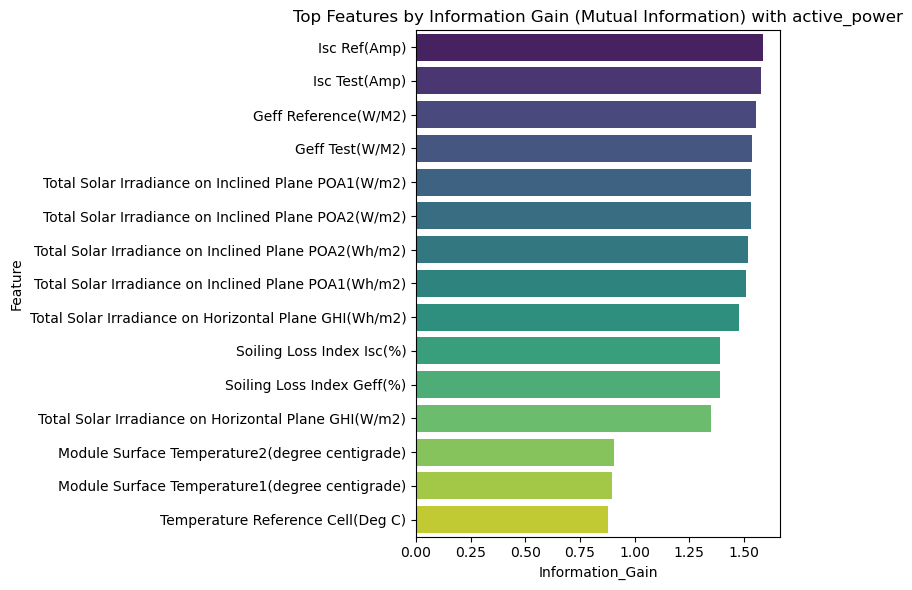

In [26]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# prepare data
X = num_df.drop(columns=['active_power'])
y = num_df['active_power']

# compute mutual information (Information Gain)
mi = mutual_info_regression(X, y, random_state=42)

# put into a dataframe
mi_df = pd.DataFrame({'Feature': X.columns, 'Information_Gain': mi})
mi_df = mi_df.sort_values('Information_Gain', ascending=False)

# print top features
print(mi_df)

# optional: visualize
plt.figure(figsize=(8, 6))
sns.barplot(data=mi_df.head(15), x='Information_Gain', y='Feature', palette='viridis')
plt.title("Top Features by Information Gain (Mutual Information) with active_power")
plt.tight_layout()
plt.show()


In [27]:
# print weakest features (lowest Information Gain)

print(mi_df)

                                              Feature  Information_Gain
16                                       Isc Ref(Amp)          1.585659
15                                      Isc Test(Amp)          1.576746
20                               Geff Reference(W/M2)          1.557232
19                                    Geff Test(W/M2)          1.535205
0   Total Solar Irradiance on Inclined Plane POA1(...          1.532890
2   Total Solar Irradiance on Inclined Plane POA2(...          1.530061
3   Total Solar Irradiance on Inclined Plane POA2(...          1.517541
1   Total Solar Irradiance on Inclined Plane POA1(...          1.510651
5   Total Solar Irradiance on Horizontal Plane GHI...          1.479010
13                          Soiling Loss Index Isc(%)          1.391385
14                         Soiling Loss Index Geff(%)          1.389609
4   Total Solar Irradiance on Horizontal Plane GHI...          1.348062
8      Module Surface Temperature2(degree centigrade)          0

In [28]:
0.000399 -1.585659

-1.58526

Top features by |Pearson|:


pearson  spearman  \
Total Solar Irradiance on Inclined Plane POA1(W...  0.985811  0.926667   
Total Solar Irradiance on Inclined Plane POA2(W...  0.985355  0.926699   
Isc Test(Amp)                                       0.982002  0.866281   
Isc Ref(Amp)                                        0.981853  0.867395   
Total Solar Irradiance on Horizontal Plane GHI(...  0.949913  0.919090   
Geff Test(W/M2)                                     0.836756  0.746034   
Geff Reference(W/M2)                                0.829262  0.740168   
Module Surface Temperature2(degree centigrade)      0.827909  0.649993   
Module Surface Temperature1(degree centigrade)      0.823684  0.646430   
Temperature Reference Cell(Deg C)                   0.819388  0.644621   
Temperature Test(Deg C)                             0.814757  0.640494   
Ambient Temp.(degree centigrade)                    0.430380  0.271174   
Wind Speed(m/s)                                     0.389136  0.427107   
Relative Humidity(%)                               -0.341819 -0.241284   
Wind direction(degree)                              0.083286  0.083104   
Total Solar Irradiance on Inclined Plane POA2(W...  0.079061  0.185769   
Total Solar Irradiance on Inclined Plane POA1(W...  0.077311  0.184843   
Total Solar Irradiance on Horizontal Plane GHI(...  0.071546  0.185347   
Soiling Loss Index Isc(%)                           0.041089  0.003551   
Soiling Loss Index Geff(%)                          0.019661 -0.109277   
Daily rain(mm)                                     -0.010111 -0.008304   

                                                          mi  pearson_abs  \
Total Solar Irradiance on Inclined Plane POA1(W...  1.532890     0.985811   
Total Solar Irradiance on Inclined Plane POA2(W...  1.530061     0.985355   
Isc Test(Amp)                                       1.576746     0.982002   
Isc Ref(Amp)                                        1.585659     0.981853   
Total Solar Irradiance on Horizontal Plane GHI(...  1.348062     0.949913   
Geff Test(W/M2)                                     1.535205     0.836756   
Geff Reference(W/M2)                                1.557232     0.829262   
Module Surface Temperature2(degree centigrade)      0.904967     0.827909   
Module Surface Temperature1(degree centigrade)      0.895517     0.823684   
Temperature Reference Cell(Deg C)                   0.880213     0.819388   
Temperature Test(Deg C)                             0.871236     0.814757   
Ambient Temp.(degree centigrade)                    0.619661     0.430380   
Wind Speed(m/s)                                     0.162032     0.389136   
Relative Humidity(%)                                0.523679     0.341819   
Wind direction(degree)                              0.162293     0.083286   
Total Solar Irradiance on Inclined Plane POA2(W...  1.517541     0.079061   
Total Solar Irradiance on Inclined Plane POA1(W...  1.510651     0.077311   
Total Solar Irradiance on Horizontal Plane GHI(...  1.479010     0.071546   
Soiling Loss Index Isc(%)                           1.391385     0.041089   
Soiling Loss Index Geff(%)                          1.389609     0.019661   
Daily rain(mm)                                      0.000399     0.010111   

                                                     mi_norm  
Total Solar Irradiance on Inclined Plane POA1(W...  0.966721  
Total Solar Irradiance on Inclined Plane POA2(W...  0.964937  
Isc Test(Amp)                                       0.994379  
Isc Ref(Amp)                                        1.000000  
Total Solar Irradiance on Horizontal Plane GHI(...  0.850159  
Geff Test(W/M2)                                     0.968181  
Geff Reference(W/M2)                                0.982073  
Module Surface Temperature2(degree centigrade)      0.570720  
Module Surface Temperature1(degree centigrade)      0.564760  
Temperature Reference Cell(Deg C)                   0.555109  
Temperature Test(Deg C)             

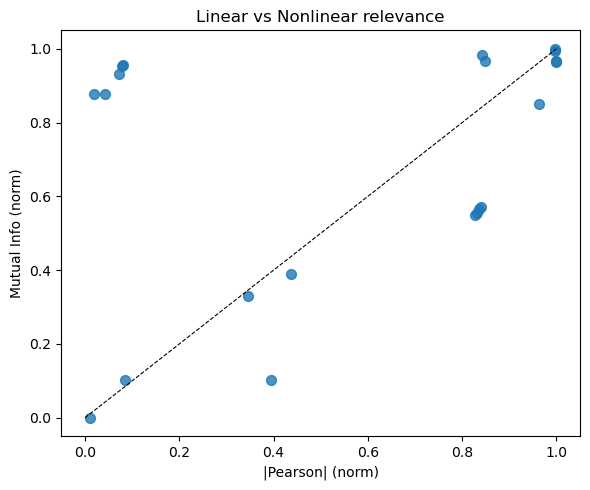

In [ ]:
# simplified feature scoring + quick visuals (keeps same concepts: Pearson, Spearman, Mutual Info)
target_col = 'active_power'
num = df_main.select_dtypes('number').copy()

# ensure target present
if target_col not in num.columns:
    raise KeyError(f"Target '{target_col}' not found in numeric dataframe")

X = num.drop(columns=[target_col])
y = num[target_col]

# scores
pearson = X.corrwith(y)
spearman = X.corrwith(y, method='spearman')
mi = pd.Series(mutual_info_regression(X.fillna(0), y.fillna(0), random_state=42),
               index=X.columns, name='mi')

scores = pd.concat([pearson.rename('pearson'), spearman.rename('spearman'), mi], axis=1)
scores['pearson_abs'] = scores['pearson'].abs()
scores['mi_norm'] = scores['mi'] / (scores['mi'].max() or 1.0)

# show top features
print("Top features by |Pearson|:")
display(scores.sort_values('pearson_abs', ascending=False))

# scatter: |Pearson| (normalized) vs MI (normalized)
plt.figure(figsize=(6,5))
plt.scatter(scores['pearson_abs'] / (scores['pearson_abs'].max() or 1.0), scores['mi_norm'], s=50, alpha=0.8)
plt.plot([0,1],[0,1],'k--', lw=0.8)
plt.xlabel('|Pearson| (norm)'); plt.ylabel('Mutual Info (norm)')
plt.title('Linear vs Nonlinear relevance')
plt.tight_layout(); plt.show()


In [77]:
display(scores.sort_values('mi_norm', ascending=False))

pearson  spearman  \
Isc Ref(Amp)                                        0.981853  0.867395   
Isc Test(Amp)                                       0.982002  0.866281   
Geff Reference(W/M2)                                0.829262  0.740168   
Geff Test(W/M2)                                     0.836756  0.746034   
Total Solar Irradiance on Inclined Plane POA1(W...  0.985811  0.926667   
Total Solar Irradiance on Inclined Plane POA2(W...  0.985355  0.926699   
Total Solar Irradiance on Inclined Plane POA2(W...  0.079061  0.185769   
Total Solar Irradiance on Inclined Plane POA1(W...  0.077311  0.184843   
Total Solar Irradiance on Horizontal Plane GHI(...  0.071546  0.185347   
Soiling Loss Index Isc(%)                           0.041089  0.003551   
Soiling Loss Index Geff(%)                          0.019661 -0.109277   
Total Solar Irradiance on Horizontal Plane GHI(...  0.949913  0.919090   
Module Surface Temperature2(degree centigrade)      0.827909  0.649993   
Module Surface Temperature1(degree centigrade)      0.823684  0.646430   
Temperature Reference Cell(Deg C)                   0.819388  0.644621   
Temperature Test(Deg C)                             0.814757  0.640494   
Ambient Temp.(degree centigrade)                    0.430380  0.271174   
Relative Humidity(%)                               -0.341819 -0.241284   
Wind direction(degree)                              0.083286  0.083104   
Wind Speed(m/s)                                     0.389136  0.427107   
Daily rain(mm)                                     -0.010111 -0.008304   

                                                          mi  pearson_abs  \
Isc Ref(Amp)                                        1.585659     0.981853   
Isc Test(Amp)                                       1.576746     0.982002   
Geff Reference(W/M2)                                1.557232     0.829262   
Geff Test(W/M2)                                     1.535205     0.836756   
Total Solar Irradiance on Inclined Plane POA1(W...  1.532890     0.985811   
Total Solar Irradiance on Inclined Plane POA2(W...  1.530061     0.985355   
Total Solar Irradiance on Inclined Plane POA2(W...  1.517541     0.079061   
Total Solar Irradiance on Inclined Plane POA1(W...  1.510651     0.077311   
Total Solar Irradiance on Horizontal Plane GHI(...  1.479010     0.071546   
Soiling Loss Index Isc(%)                           1.391385     0.041089   
Soiling Loss Index Geff(%)                          1.389609     0.019661   
Total Solar Irradiance on Horizontal Plane GHI(...  1.348062     0.949913   
Module Surface Temperature2(degree centigrade)      0.904967     0.827909   
Module Surface Temperature1(degree centigrade)      0.895517     0.823684   
Temperature Reference Cell(Deg C)                   0.880213     0.819388   
Temperature Test(Deg C)                             0.871236     0.814757   
Ambient Temp.(degree centigrade)                    0.619661     0.430380   
Relative Humidity(%)                                0.523679     0.341819   
Wind direction(degree)                              0.162293     0.083286   
Wind Speed(m/s)                                     0.162032     0.389136   
Daily rain(mm)                                      0.000399     0.010111   

                                                     mi_norm  
Isc Ref(Amp)                                        1.000000  
Isc Test(Amp)                                       0.994379  
Geff Reference(W/M2)                                0.982073  
Geff Test(W/M2)                                     0.968181  
Total Solar Irradiance on Inclined Plane POA1(W...  0.966721  
Total Solar Irradiance on Inclined Plane POA2(W...  0.964937  
Total Solar Irradiance on Inclined Plane POA2(W...  0.957041  
Total Solar Irradiance on Inclined Plane POA1(W...  0.952696  
Total Solar Irradiance on Horizontal Plane GHI(...  0.932741  
Soiling Loss Index Isc(%)                           0.877480  
Soiling Loss Index Geff(%)          

### Comparative Training Strategy

Since Pearson Correlation (PCC) and Information Gain (IG) capture distinct relationships —
linear vs nonlinear — two separate training pipelines were established:

1. **PCC-based models:** trained only on features with strong linear correlation to `active_power`.
2. **IG-based models:** trained on features with high mutual information (nonlinear dependencies).

This dual-model approach allows direct comparison of how linear vs nonlinear features
affect forecasting accuracy across both XGBoost and LSTM architectures.


In [30]:
"""# two sets of features from your earlier analysis
features_pcc = [
    'Total Solar Irradiance on Inclined Plane POA1(W/m2)',
    'Total Solar Irradiance on Inclined Plane POA2(W/m2)',
    'Isc Test(Amp)',
    'Isc Ref(Amp)',
    'Total Solar Irradiance on Horizontal Plane GHI(W/m2)',
    'Geff Test(W/M2)',
    'Geff Reference(W/M2)',
    'Module Surface Temperature2(degree centigrade)',
    'Module Surface Temperature1(degree centigrade)',
    'Temperature Reference Cell(Deg C)',
    'Temperature Test(Deg C)',
    'Ambient Temp.(degree centigrade)',
    'Wind Speed(m/s)',
    'Relative Humidity(%)'
]

features_ig = [
    'Isc Ref(Amp)',
    'Isc Test(Amp)',
    'Geff Reference(W/M2)',
    'Geff Test(W/M2)',
    'Total Solar Irradiance on Inclined Plane POA1(W/m2)',
    'Total Solar Irradiance on Inclined Plane POA2(W/m2)',
    'Soiling Loss Index Geff(%)',
    'Soiling Loss Index Isc(%)',
    'Module Surface Temperature2(degree centigrade)',
    'Module Surface Temperature1(degree centigrade)',
    'Temperature Reference Cell(Deg C)',
    'Total Solar Irradiance on Horizontal Plane GHI(W/m2)',
]

TARGET = "active_power"
"""

'# two sets of features from your earlier analysis\nfeatures_pcc = [\n    \'Total Solar Irradiance on Inclined Plane POA1(W/m2)\',\n    \'Total Solar Irradiance on Inclined Plane POA2(W/m2)\',\n    \'Isc Test(Amp)\',\n    \'Isc Ref(Amp)\',\n    \'Total Solar Irradiance on Horizontal Plane GHI(W/m2)\',\n    \'Geff Test(W/M2)\',\n    \'Geff Reference(W/M2)\',\n    \'Module Surface Temperature2(degree centigrade)\',\n    \'Module Surface Temperature1(degree centigrade)\',\n    \'Temperature Reference Cell(Deg C)\',\n    \'Temperature Test(Deg C)\',\n    \'Ambient Temp.(degree centigrade)\',\n    \'Wind Speed(m/s)\',\n    \'Relative Humidity(%)\'\n]\n\nfeatures_ig = [\n    \'Isc Ref(Amp)\',\n    \'Isc Test(Amp)\',\n    \'Geff Reference(W/M2)\',\n    \'Geff Test(W/M2)\',\n    \'Total Solar Irradiance on Inclined Plane POA1(W/m2)\',\n    \'Total Solar Irradiance on Inclined Plane POA2(W/m2)\',\n    \'Soiling Loss Index Geff(%)\',\n    \'Soiling Loss Index Isc(%)\',\n    \'Module Surface Temp

In [31]:
features_pcc = [
    "Relative Humidity(%)",
    "Wind Speed(m/s)",
    "Ambient Temp.(degree centigrade)",
    "Temperature Test(Deg C)",
    "Temperature Reference Cell(Deg C)",
    "Module Surface Temperature1(degree centigrade)",
    "Module Surface Temperature2(degree centigrade)",
    "Geff Reference(W/M2)",
    "Geff Test(W/M2)",
    "Total Solar Irradiance on Horizontal Plane GHI(W/m2)"
]


features_ig = [
    "Total Solar Irradiance on Horizontal Plane GHI(Wh/m2)",
    "Soiling Loss Index Isc(%)",
    "Soiling Loss Index Geff(%)",
    "Total Solar Irradiance on Horizontal Plane GHI(W/m2)",
    "Module Surface Temperature2(degree centigrade)",
    "Module Surface Temperature1(degree centigrade)",
    "Temperature Reference Cell(Deg C)",
    "Temperature Test(Deg C)",
    "Ambient Temp.(degree centigrade)",
    "Relative Humidity(%)"
]
TARGET = "active_power"

# XGBoost

In [32]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor



In [33]:
# 1) Build feature matrices
X_pcc_s = df_main[features_pcc].copy()
X_ig_s  = df_main[features_ig].copy()
y     = df_main[TARGET].copy()

In [34]:
"""# 2) Scale features (keeps target unscaled)
scaler_pcc = StandardScaler()
scaler_ig  = StandardScaler()
X_pcc_s = pd.DataFrame(scaler_pcc.fit_transform(X_pcc), index=X_pcc.index, columns=X_pcc.columns)
X_ig_s  = pd.DataFrame(scaler_ig.fit_transform(X_ig),   index=X_ig.index,   columns=X_ig.columns)
"""

'# 2) Scale features (keeps target unscaled)\nscaler_pcc = StandardScaler()\nscaler_ig  = StandardScaler()\nX_pcc_s = pd.DataFrame(scaler_pcc.fit_transform(X_pcc), index=X_pcc.index, columns=X_pcc.columns)\nX_ig_s  = pd.DataFrame(scaler_ig.fit_transform(X_ig),   index=X_ig.index,   columns=X_ig.columns)\n'

In [35]:
"""import joblib
joblib.dump(scaler_ig, "scaler_ig.pkl")
joblib.dump(scaler_pcc, "scaler_pcc.pkl")
"""

'import joblib\njoblib.dump(scaler_ig, "scaler_ig.pkl")\njoblib.dump(scaler_pcc, "scaler_pcc.pkl")\n'

In [36]:
print(X_pcc_s.head())
print(X_ig_s.head())

                     Relative Humidity(%)  Wind Speed(m/s)  \
Time                                                         
2020-01-01 00:01:00             69.008003              0.0   
2020-01-01 00:02:00             69.246002              0.0   
2020-01-01 00:03:00             69.517998              0.0   
2020-01-01 00:04:00             69.666000              0.0   
2020-01-01 00:05:00             69.289001              0.0   

                     Ambient Temp.(degree centigrade)  \
Time                                                    
2020-01-01 00:01:00                             4.826   
2020-01-01 00:02:00                             4.754   
2020-01-01 00:03:00                             4.714   
2020-01-01 00:04:00                             4.766   
2020-01-01 00:05:00                             4.835   

                     Temperature Test(Deg C)  \
Time                                           
2020-01-01 00:01:00                 1.642548   
2020-01-01 00:02:00  

In [37]:
# 3) Chronological split (e.g., last 20% = test)
split_idx = int(len(df_main) * 0.80)

def time_split(X, y, split_idx):
    X_train, X_test = X.iloc[:split_idx],  X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx],  y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

Xp_tr, Xp_te, yp_tr, yp_te = time_split(X_pcc_s, y, split_idx)
Xi_tr, Xi_te, yi_tr, yi_te = time_split(X_ig_s,  y, split_idx)

In [38]:
print("xgboost version:", xgb.__version__)

xgboost version: 2.1.1


In [39]:
import itertools

def train_xgb_single(X_tr, y_tr, X_va, y_va, label,
                     num_boost_round=2000, early_stopping_rounds=100, seed=42,
                     base_params=None):
    # containers
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_va, label=y_va)

    # default params (can be overridden by base_params)
    params = {
        "objective": "reg:squarederror",  # squared error => MSE loss
        "eval_metric": "rmse",            
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 1.0,
        "tree_method": "hist",
        "seed": seed,
    }
    if base_params:
        params.update(base_params)

    evals = [(dtrain, "train"), (dvalid, "valid")]
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=True,
    )

    # predictions using best_iteration
    pred = booster.predict(dvalid, iteration_range=(0, booster.best_iteration + 1))

    # metrics
    mse  = float(np.mean((y_va - pred) ** 2))
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_va, pred))
    r2   = float(r2_score(y_va, pred))

    print(f"\n--- {label} ---")
    print(f"Best Iteration : {booster.best_iteration}")
    print(f"MSE            : {mse:.6f}")
    print(f"RMSE           : {rmse:.6f}")
    print(f"MAE            : {mae:.6f}")
    print(f"R2             : {r2:.6f}")

    return booster, pred, {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "best_iteration": booster.best_iteration}


def grid_search_xgb(
    X_tr, y_tr, X_va, y_va, label="XGB",
    num_boost_round=2000, early_stopping_rounds=100, seed=42,
    param_grid=None, fixed_params=None
):
    """
    param_grid: dict of lists, e.g. {
        "eta": [0.03, 0.05],
        "max_depth": [4, 6, 8],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "reg_lambda": [0.0, 1.0],
        "min_child_weight": [1, 5],
        "gamma": [0.0, 1.0],
    }
    fixed_params: dict of constant params to keep across all trials
    """
    if param_grid is None:
        param_grid = {
            "eta": [0.03, 0.05],
            "max_depth": [4, 6, 8],
            "subsample": [0.7, 0.9],
            "colsample_bytree": [0.7, 0.9],
            "reg_lambda": [0.0, 1.0],
        }
    if fixed_params is None:
        fixed_params = {}

    keys = list(param_grid.keys())
    combos = list(itertools.product(*[param_grid[k] for k in keys]))

    results = []
    best = {"mse": np.inf, "booster": None, "params": None, "metrics": None}

    print(f"Total trials: {len(combos)}")

    for i, values in enumerate(combos, start=1):
        trial_params = dict(zip(keys, values))
        trial_params.update(fixed_params)  # override/add fixed params

        # train one model
        booster, pred, metrics = train_xgb_single(
            X_tr, y_tr, X_va, y_va,
            label=f"{label} | trial {i}",
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            seed=seed,
            base_params=trial_params
        )

        # print compact line per trial
        short = {k: trial_params[k] for k in keys}
        print(f"[trial {i:03d}] params={short} | MSE={metrics['mse']:.6f} "
              f"RMSE={metrics['rmse']:.6f} MAE={metrics['mae']:.6f} "
              f"R2={metrics['r2']:.6f} best_it={metrics['best_iteration']}")

        # collect
        row = {"trial": i, **trial_params, **metrics}
        results.append(row)

        # track best by MSE
        if metrics["mse"] < best["mse"]:
            best = {"mse": metrics["mse"], "booster": booster, "params": trial_params, "metrics": metrics}

    results_df = pd.DataFrame(results).sort_values("mse").reset_index(drop=True)
    print("\n=== Top 5 by MSE ===")
    print(results_df[["trial", *keys, "mse", "rmse", "mae", "r2", "best_iteration"]].head(5).to_string(index=False))

    return best["booster"], best["params"], results_df


In [40]:

param_grid = {
    "eta": [0.02, 0.03, 0.05],
    "max_depth": [4, 6, 8],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "reg_lambda": [0.0, 1.0],
    "min_child_weight": [1, 5],
}

fixed_params = {
    "tree_method": "hist",        
    "eval_metric": "rmse",       
    "objective": "reg:squarederror",
}

## pcc booster

In [41]:
booster_pcc, best_params_pcc, results_df_pcc = grid_search_xgb(
    Xp_tr, yp_tr, Xp_te, yp_te,
    label="ActivePower-XGB",
    num_boost_round=2000,
    early_stopping_rounds=100,
    seed=42,
    param_grid=param_grid,
    fixed_params=fixed_params
)

print("\nBest params by MSE:")
print(best_params_pcc)

Total trials: 144
[0]	train-rmse:129440.26230	valid-rmse:109177.31512
[1]	train-rmse:126920.87636	valid-rmse:106902.29821
[2]	train-rmse:124452.92001	valid-rmse:104673.08010
[3]	train-rmse:122035.82728	valid-rmse:102475.44419
[4]	train-rmse:119668.01282	valid-rmse:100340.13912
[5]	train-rmse:117349.14332	valid-rmse:98248.79942
[6]	train-rmse:115124.02488	valid-rmse:96198.36323
[7]	train-rmse:112898.30313	valid-rmse:94181.31811
[8]	train-rmse:110798.04088	valid-rmse:92303.38079
[9]	train-rmse:108707.72069	valid-rmse:90375.85744
[10]	train-rmse:106661.56721	valid-rmse:88493.37557
[11]	train-rmse:104606.35888	valid-rmse:86643.13855
[12]	train-rmse:102595.11461	valid-rmse:84819.97091
[13]	train-rmse:100625.46467	valid-rmse:83039.03398
[14]	train-rmse:98741.90343	valid-rmse:81311.84130
[15]	train-rmse:96852.04297	valid-rmse:79601.89561
[16]	train-rmse:95049.88302	valid-rmse:77932.41596
[17]	train-rmse:93234.94028	valid-rmse:76292.05405
[18]	train-rmse:91457.60592	valid-rmse:74688.52806
[19]

In [42]:
# final predictions on test set
pred_pcc = booster_pcc.predict(xgb.DMatrix(Xp_te))

mse_pcc = mean_squared_error(yp_te, pred_pcc)
r2_pcc  = r2_score(yp_te, pred_pcc)

print(f"MSE (PCC): {mse_pcc:.4f} | R² (PCC): {r2_pcc:.4f}")


MSE (PCC): 399195865.7386 | R² (PCC): 0.9635


In [43]:
#save the model
booster_pcc.save_model("xgb_pcc_model.json")

## ig booster

In [44]:
booster_ig, best_params_ig, results_df_ig = grid_search_xgb(
    Xi_tr, yi_tr, Xi_te, yi_te,
    label="ActivePower-XGB",
    num_boost_round=2000,
    early_stopping_rounds=100,
    seed=42,
    param_grid=param_grid,
    fixed_params=fixed_params
)

print("\nBest params by MSE:")
print(best_params_ig)

Total trials: 144
[0]	train-rmse:129441.80349	valid-rmse:109168.58183
[1]	train-rmse:126924.12190	valid-rmse:106878.57913
[2]	train-rmse:124606.41051	valid-rmse:104857.09193
[3]	train-rmse:122186.52417	valid-rmse:102657.25710
[4]	train-rmse:119975.33973	valid-rmse:100731.88294
[5]	train-rmse:117808.92571	valid-rmse:98856.91670
[6]	train-rmse:115631.53759	valid-rmse:96926.76783
[7]	train-rmse:113396.44438	valid-rmse:94897.39233
[8]	train-rmse:111206.13768	valid-rmse:92916.44207
[9]	train-rmse:109240.59083	valid-rmse:91212.42089
[10]	train-rmse:107136.08884	valid-rmse:89310.18670
[11]	train-rmse:105073.82935	valid-rmse:87446.16120
[12]	train-rmse:103271.34994	valid-rmse:85835.17795
[13]	train-rmse:101290.72564	valid-rmse:84046.09112
[14]	train-rmse:99528.11338	valid-rmse:82529.23499
[15]	train-rmse:97820.91043	valid-rmse:81055.08778
[16]	train-rmse:95953.57091	valid-rmse:79351.91026
[17]	train-rmse:94124.72658	valid-rmse:77701.42665
[18]	train-rmse:92334.32702	valid-rmse:76065.47708
[19]

In [45]:
# final predictions on test set

pred_ig  = booster_ig.predict(xgb.DMatrix(Xi_te))

mse_ig  = mean_squared_error(yi_te, pred_ig)
r2_ig   = r2_score(yi_te, pred_ig)      

print(f"MSE (IG) : {mse_ig:.4f}  | R² (IG) : {r2_ig:.4f}")  

MSE (IG) : 383437475.8009  | R² (IG) : 0.9649


In [46]:
#save the model
booster_ig.save_model("xgb_ig_model.json")

In [47]:
import numpy as np
import pandas as pd

# y_test & predictions (pred_pcc, pred_ig) already computed above
y_true = y.iloc[split_idx:]
pred_pcc_series = pd.Series(pred_pcc, index=y_true.index)
pred_ig_series  = pd.Series(pred_ig,  index=y_true.index)

# helper metrics
def mape(y, yhat, eps=1e-6):
    y = y.astype(float)
    return np.mean(np.abs((y - yhat) / np.maximum(np.abs(y), eps))) * 100

def smape(y, yhat, eps=1e-6):
    num = np.abs(yhat - y)
    den = (np.abs(y) + np.abs(yhat)) / 2.0
    return np.mean(num / np.maximum(den, eps)) * 100

def nrmse(y, yhat):
    rmse = np.sqrt(np.mean((y - yhat)**2))
    return {
        "by_range_%": rmse / (y.max() - y.min()) * 100,
        "by_std_%":   rmse / (y.std(ddof=0) + 1e-9) * 100
    }

# define daytime mask (use irradiance if available; fallback to power threshold)
if 'Total Solar Irradiance on Horizontal Plane GHI(W/m2)' in df_main.columns:
    ghi = df_main['Total Solar Irradiance on Horizontal Plane GHI(W/m2)'].reindex(y_true.index)
    day_mask = ghi > 50  # tweak as needed
else:
    day_mask = y_true > 1000  # fallback threshold

def summarize(y, yhat, tag):
    res = {}
    res['MAE']  = np.mean(np.abs(y - yhat))
    res['RMSE'] = np.sqrt(np.mean((y - yhat)**2))
    res['R2']   = 1 - np.sum((y - yhat)**2) / np.sum((y - y.mean())**2)
    res['MAPE_%']  = mape(y, yhat)
    res['sMAPE_%'] = smape(y, yhat)
    res.update({f'NRMSE_{k}': v for k, v in nrmse(y, yhat).items()})
    # daytime-only
    y_d, yh_d = y[day_mask], yhat[day_mask]
    res['DAY_MAE']      = np.mean(np.abs(y_d - yh_d))
    res['DAY_MAPE_%']   = mape(y_d, yh_d)
    res['DAY_sMAPE_%']  = smape(y_d, yh_d)
    return pd.Series(res, name=tag)

# baselines (same-time evaluation; simple references)
# 1) last-value baseline (1-step persistence)
baseline_last = y_true.shift(1).bfill()
# 2) yesterday-same-minute baseline (if test has >= 1440 mins)
daily_lag = 1440
baseline_yday = y_true.shift(daily_lag).bfill()

tbl = pd.concat([
    summarize(y_true, baseline_last, "Baseline_Last"),
    summarize(y_true, baseline_yday, "Baseline_Yesterday"),
    summarize(y_true, pred_pcc_series, "XGB_PCC"),
    summarize(y_true, pred_ig_series,  "XGB_IG"),
], axis=1)

print(tbl.round(3))


                  Baseline_Last  Baseline_Yesterday    XGB_PCC     XGB_IG
MAE                    1312.791           16820.876   8938.423  10196.840
RMSE                   4982.626           45042.510  19979.887  19581.560
R2                        0.998               0.815      0.964      0.965
MAPE_%                    4.628              39.115     42.850    138.083
sMAPE_%                   2.522              17.754     55.906    118.362
NRMSE_by_range_%          1.648              14.902      6.610      6.478
NRMSE_by_std_%            4.764              43.067     19.103     18.723
DAY_MAE                3310.921           41570.760  22093.263  23751.565
DAY_MAPE_%                2.652              38.535     14.206     16.087
DAY_sMAPE_%               2.625              31.222     13.635     14.308


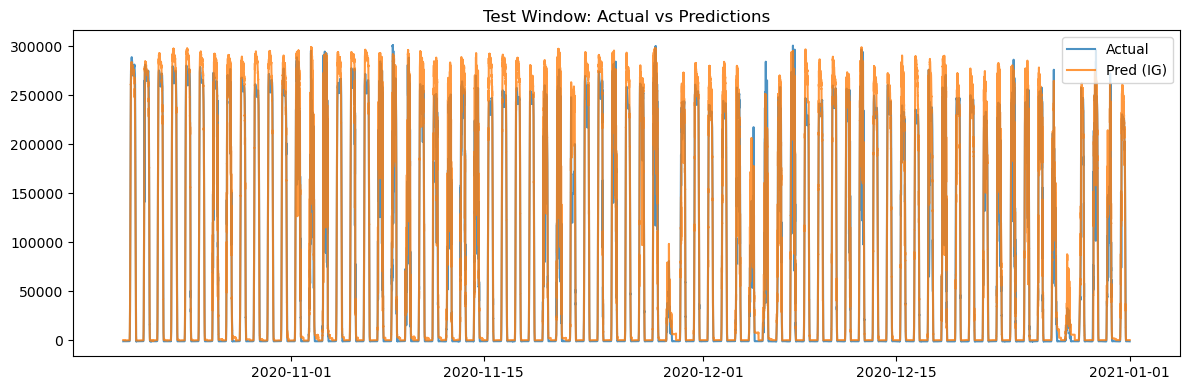

In [48]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y.index[split_idx:], y.iloc[split_idx:], label="Actual", alpha=0.8)
plt.plot(y.index[split_idx:], pred_ig,  label="Pred (IG)",  alpha=0.8)
plt.title("Test Window: Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

-------------------------------------

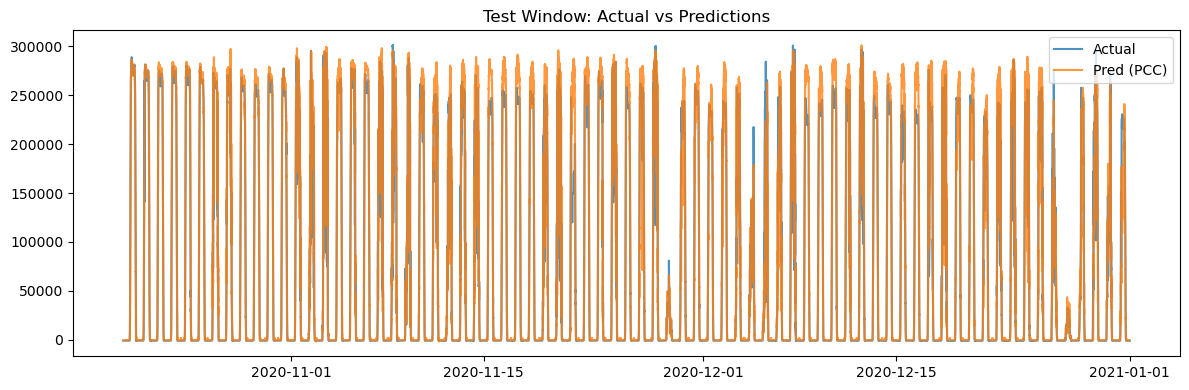

In [50]:
#neeeewwww
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y.index[split_idx:], y.iloc[split_idx:], label="Actual", alpha=0.8)
plt.plot(y.index[split_idx:], pred_pcc, label="Pred (PCC)", alpha=0.8)
plt.title("Test Window: Actual vs Predictions")
plt.legend(); plt.tight_layout(); plt.show()

# Important Features

<Figure size 800x600 with 0 Axes>

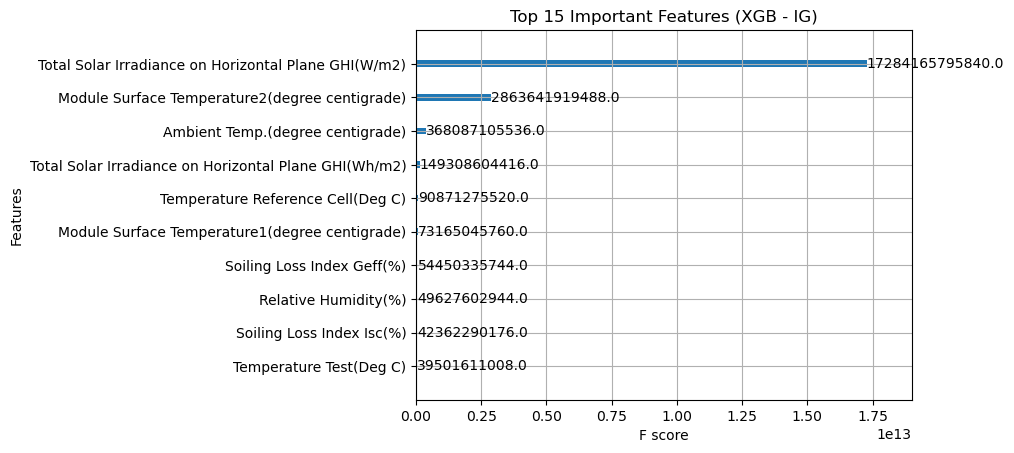

In [51]:
from xgboost import plot_importance
plt.figure(figsize=(8, 6))
plot_importance(booster_ig, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGB - IG)")
plt.show()


<Figure size 800x600 with 0 Axes>

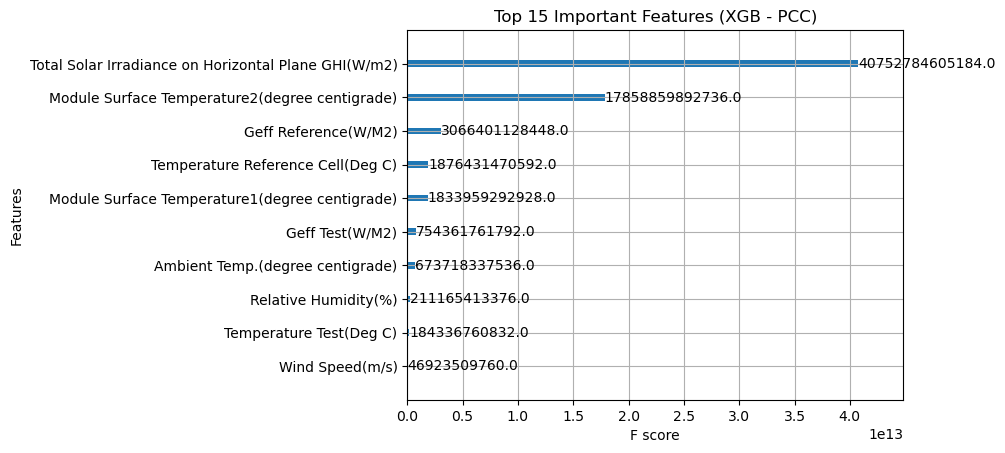

In [52]:
from xgboost import plot_importance
plt.figure(figsize=(8, 6))
plot_importance(booster_pcc, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGB - PCC)")
plt.show()


# Residual Distribution

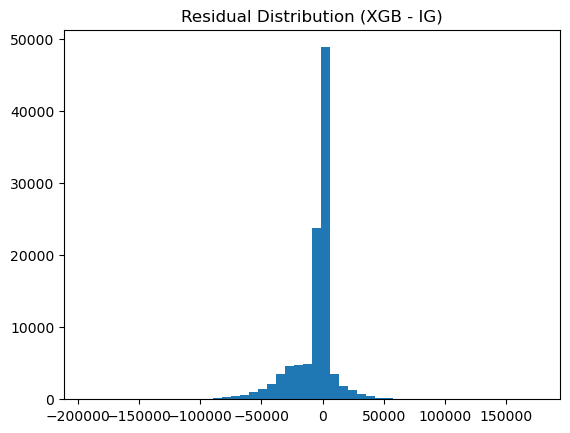

In [53]:
residuals = yi_te - pred_ig
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (XGB - IG)")
plt.show()


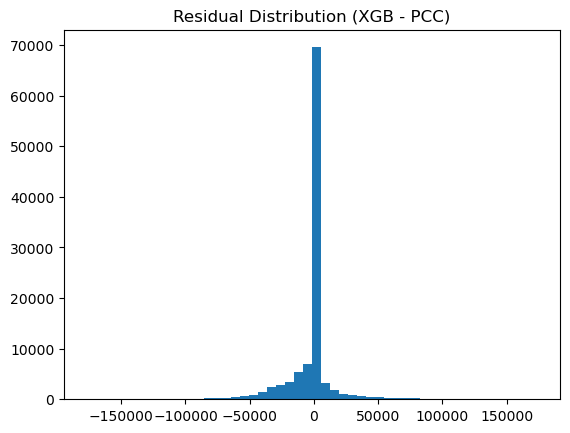

In [54]:
residuals = yi_te - pred_pcc
plt.hist(residuals, bins=50)
plt.title("Residual Distribution (XGB - PCC)")
plt.show()

# forcasting for 24 hours after last set of data 

/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/1986837993.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_future_hourly = y_future.resample("1H").mean()


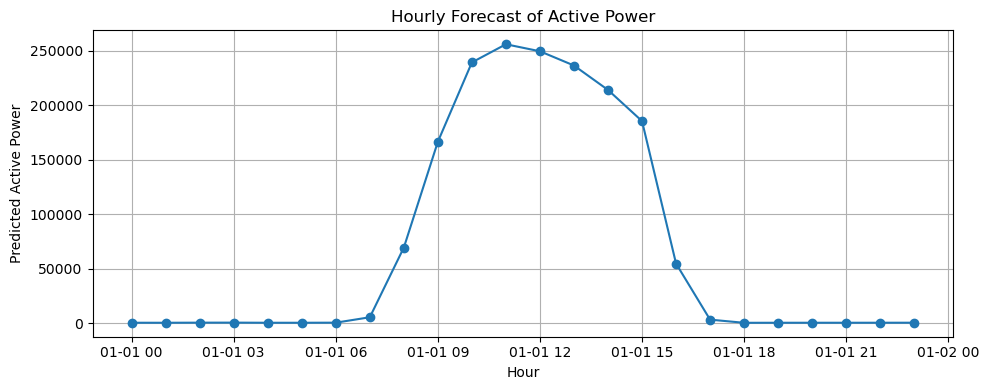

In [55]:

model = booster_ig
FEATS = features_ig
HORIZON = 24 * 60
FREQ = "1min"

last_ts = df_main.index[-1]
future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=1), periods=HORIZON, freq=FREQ)

one_day = 1440
hist_exo = df_main[FEATS].iloc[-one_day:]
repeats = int(np.ceil(HORIZON / one_day))
future_exo = pd.concat([hist_exo] * repeats, axis=0).iloc[:HORIZON]
future_exo.index = future_idx
future_exo.columns = FEATS

preds = model.predict(xgb.DMatrix(future_exo, feature_names=FEATS))
y_future = pd.Series(preds, index=future_idx, name="active_power_pred")

y_future_hourly = y_future.resample("1H").mean()

plt.figure(figsize=(10, 4))
plt.plot(y_future_hourly.index, y_future_hourly.values, marker="o")
plt.title("Hourly Forecast of Active Power")
plt.xlabel("Hour")
plt.ylabel("Predicted Active Power")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/fc/3f5dtyyn2m589pf7gzyk878m0000gn/T/ipykernel_90923/2710908422.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_future_hourly = y_future.resample("1H").mean()


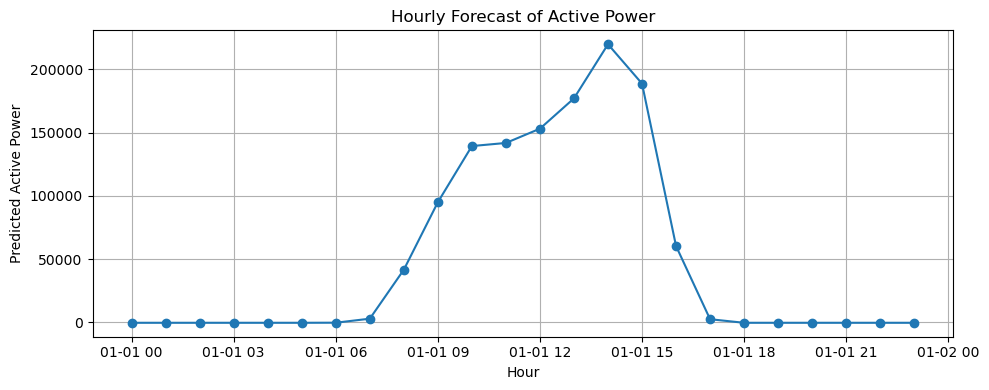

In [58]:

model = booster_pcc
FEATS = features_pcc
HORIZON = 24 * 60
FREQ = "1min"

last_ts = df_main.index[-1]
future_idx = pd.date_range(last_ts + pd.Timedelta(minutes=1), periods=HORIZON, freq=FREQ)

one_day = 1440
hist_exo = df_main[FEATS].iloc[-one_day:]
repeats = int(np.ceil(HORIZON / one_day))
future_exo = pd.concat([hist_exo] * repeats, axis=0).iloc[:HORIZON]
future_exo.index = future_idx
future_exo.columns = FEATS

preds = model.predict(xgb.DMatrix(future_exo, feature_names=FEATS))
y_future = pd.Series(preds, index=future_idx, name="active_power_pred")

y_future_hourly = y_future.resample("1H").mean()

plt.figure(figsize=(10, 4))
plt.plot(y_future_hourly.index, y_future_hourly.values, marker="o")
plt.title("Hourly Forecast of Active Power")
plt.xlabel("Hour")
plt.ylabel("Predicted Active Power")
plt.grid(True)
plt.tight_layout()
plt.show()


MAE: 10,196.84 | RMSE: 383,437,475.80 | R²: 0.965


actual   predicted        error
Time                                                   
2020-10-19 19:12:00 -906.42710  250.970276  1157.397376
2020-10-19 19:13:00 -909.76590  250.970276  1160.736176
2020-10-19 19:14:00 -907.49830  250.970276  1158.468576
2020-10-19 19:15:00 -908.13214  250.970276  1159.102416
2020-10-19 19:16:00 -898.49470  250.970276  1149.464976

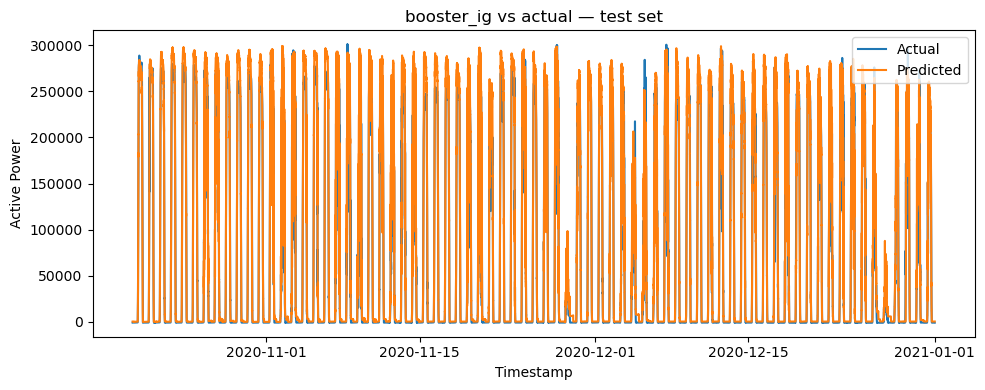

In [56]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# make sure Xi_te / yi_te are still the IG-based test split from `time_split`
dtest = xgb.DMatrix(Xi_te, label=yi_te)

y_pred = booster_ig.predict(dtest)
y_true = yi_te

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

comparison = (
    pd.DataFrame({"actual": y_true.values, "predicted": y_pred}, index=y_true.index)
      .assign(error=lambda df: df["predicted"] - df["actual"])
)

display(comparison.head())

plt.figure(figsize=(10,4))
plt.plot(comparison.index, comparison["actual"], label="Actual")
plt.plot(comparison.index, comparison["predicted"], label="Predicted")
plt.title("booster_ig vs actual — test set")
plt.xlabel("Timestamp")
plt.ylabel("Active Power")
plt.legend()
plt.tight_layout()
plt.show()


MAE: 8,938.42 | RMSE: 399,195,865.74 | R²: 0.964


actual   predicted       error
Time                                                  
2020-10-19 19:12:00 -906.42710 -450.967468  455.459632
2020-10-19 19:13:00 -909.76590 -440.459656  469.306244
2020-10-19 19:14:00 -907.49830 -411.338501  496.159799
2020-10-19 19:15:00 -908.13214 -440.459656  467.672484
2020-10-19 19:16:00 -898.49470 -440.459656  458.035044

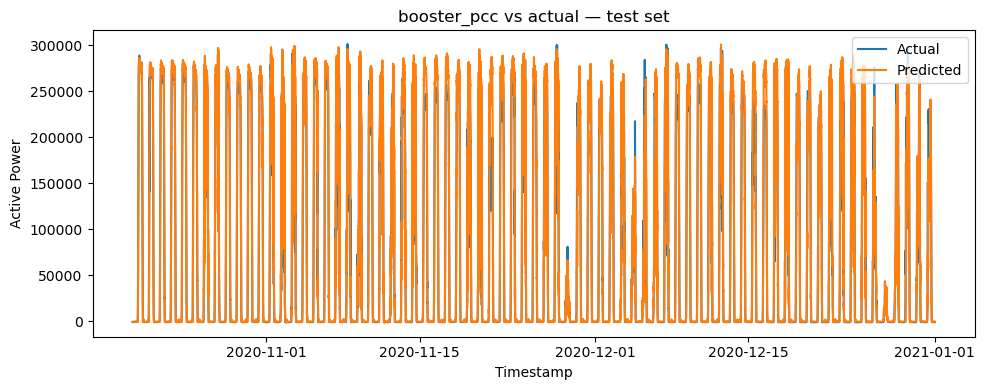

In [62]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# make sure Xi_te / yi_te are still the IG-based test split from `time_split`
dtest = xgb.DMatrix(Xp_te, label=yp_te)

y_pred = booster_pcc.predict(dtest)
y_true = yp_te

mae  = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

comparison = (
    pd.DataFrame({"actual": y_true.values, "predicted": y_pred}, index=y_true.index)
      .assign(error=lambda df: df["predicted"] - df["actual"])
)

display(comparison.head())

plt.figure(figsize=(10,4))
plt.plot(comparison.index, comparison["actual"], label="Actual")
plt.plot(comparison.index, comparison["predicted"], label="Predicted")
plt.title("booster_pcc vs actual — test set")
plt.xlabel("Timestamp")
plt.ylabel("Active Power")
plt.legend()
plt.tight_layout()
plt.show()


### IG booster is a little better 

# Vanilla Multivariate Single-Step LSTM Model

In [63]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

2025-10-22 04:06:27.612391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.18.1
Keras: 3.6.0


In [64]:
# put this at the VERY top of your notebook, before importing keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"   # ensure TF backend for Keras 3

import keras
from keras import layers, models, callbacks, optimizers
import joblib


i just choose IG features for lstm model cause it gave better results in xgboost model

In [65]:
# ---- Config ----
TARGET = "active_power"
FEATS  = features_ig            # or features_pcc
WINDOW_SIZES = [30, 60, 120]
HORIZON = 1
VAL_FRAC = 0.10
TEST_FRAC = 0.20
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 10
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [76]:
#save df_main to csv
df_main.to_csv("cleaned_data.csv", index=False)

In [66]:
# ---- Split chronologically ----
df = df_main.sort_index().copy()
n = len(df)
test_cut = int(n * (1 - TEST_FRAC))
trainval, test = df.iloc[:test_cut], df.iloc[test_cut:]
val_cut = int(len(trainval) * (1 - VAL_FRAC))
train, val = trainval.iloc[:val_cut], trainval.iloc[val_cut:]

X_train, X_val, X_test = train[FEATS].values, val[FEATS].values, test[FEATS].values
y_train, y_val, y_test = train[TARGET].values.reshape(-1,1), val[TARGET].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)

In [67]:
# ---- Scale features ----
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train, X_val, X_test = x_scaler.transform(X_train), x_scaler.transform(X_val), x_scaler.transform(X_test)
y_train, y_val, y_test = y_scaler.transform(y_train), y_scaler.transform(y_val), y_scaler.transform(y_test)

def make_sequences(X, y, window, horizon=1):
    xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        xs.append(X[i:i+window])
        ys.append(y[i+window+horizon-1, 0])
    return np.asarray(xs, np.float32), np.asarray(ys, np.float32)

def build_lstm(input_shape):
    model = models.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dropout(0.1), 
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

def inverse_metrics(y_true_sc, y_pred_sc):
    yt = y_scaler.inverse_transform(y_true_sc.reshape(-1,1)).ravel()
    yp = y_scaler.inverse_transform(y_pred_sc.reshape(-1,1)).ravel()
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    r2   = r2_score(yt, yp)
    return mae, rmse, r2, yt, yp

results = {}

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 85s 55ms/step - loss: 0.0871 - mae: 0.2026 - mape: 104.3742 - val_loss: 0.0101 - val_mae: 0.0764 - val_mape: 23.3172 - learning_rate: 0.0010
Epoch 2/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 0.0484 - mae: 0.1422 - mape: 92.4296 - val_loss: 0.0073 - val_mae: 0.0618 - val_mape: 18.1168 - learning_rate: 0.0010
Epoch 3/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 0.0445 - mae: 0.1296 - mape: 86.9873 - val_loss: 0.0061 - val_mae: 0.0554 - val_mape: 14.5369 - learning_rate: 0.0010
Epoch 4/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - loss: 0.0430 - mae: 0.1246 - mape: 86.1539 - val_loss: 0.0053 - val_mae: 0.0498 - val_mape: 13.0478 - learning_rate: 0.0010
Epoch 5/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 0.0414 - mae: 0.1195 - mape: 82.5472 - val_loss: 0.0049 - val_mae: 0.0471 - val_mape: 12.2854 - learning_rate: 0.0010
Epoch 6/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - loss: 0.0404 - mae: 0.116

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


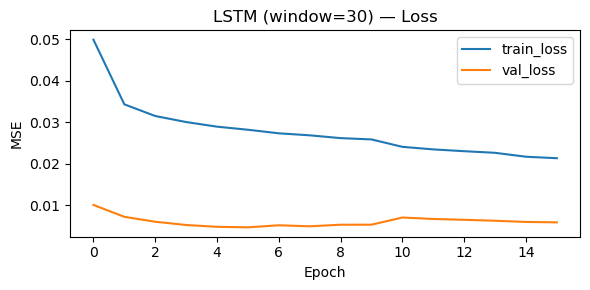

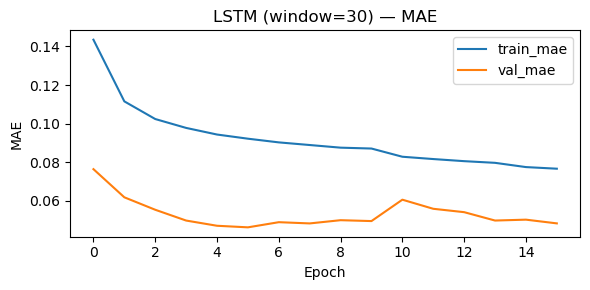

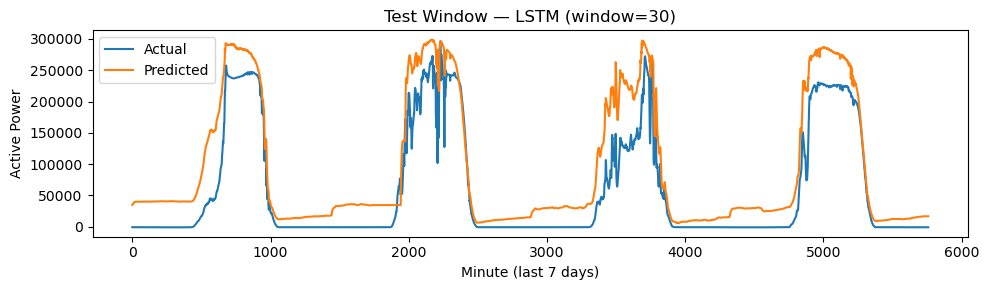

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 156s 103ms/step - loss: 0.0910 - mae: 0.2029 - mape: 95.0638 - val_loss: 0.0115 - val_mae: 0.0847 - val_mape: 25.9233 - learning_rate: 0.0010
Epoch 2/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 160s 108ms/step - loss: 0.0474 - mae: 0.1395 - mape: 92.0620 - val_loss: 0.0077 - val_mae: 0.0653 - val_mape: 17.7640 - learning_rate: 0.0010
Epoch 3/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 162s 109ms/step - loss: 0.0437 - mae: 0.1266 - mape: 85.2066 - val_loss: 0.0069 - val_mae: 0.0613 - val_mape: 16.3677 - learning_rate: 0.0010
Epoch 4/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 173s 117ms/step - loss: 0.0423 - mae: 0.1232 - mape: 82.7628 - val_loss: 0.0058 - val_mae: 0.0530 - val_mape: 14.0974 - learning_rate: 0.0010
Epoch 5/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 174s 117ms/step - loss: 0.0412 - mae: 0.1197 - mape: 81.4173 - val_loss: 0.0053 - val_mae: 0.0496 - val_mape: 12.9894 - learning_rate: 0.0010
Epoch 6/200
1483/1483 ━━━━━━━━━━━━━━━━━━━━ 174s 117ms/step - loss: 0.0396 -

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


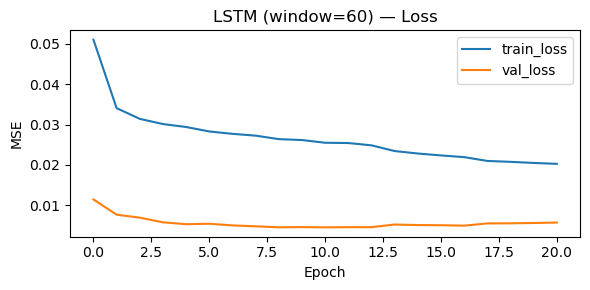

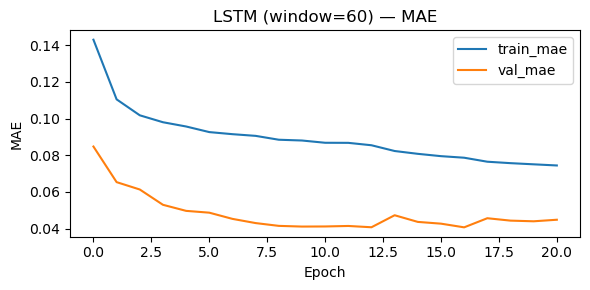

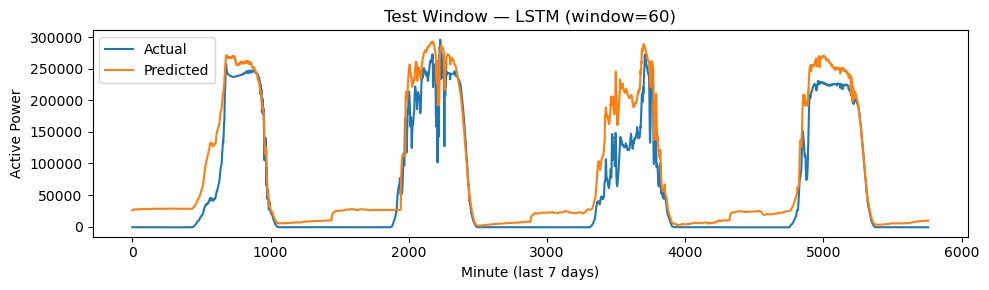

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 295s 197ms/step - loss: 0.0737 - mae: 0.1889 - mape: 97.8654 - val_loss: 0.0089 - val_mae: 0.0651 - val_mape: 20.3809 - learning_rate: 0.0010
Epoch 2/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 285s 192ms/step - loss: 0.0473 - mae: 0.1396 - mape: 91.6162 - val_loss: 0.0074 - val_mae: 0.0619 - val_mape: 18.0644 - learning_rate: 0.0010
Epoch 3/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 288s 194ms/step - loss: 0.0443 - mae: 0.1292 - mape: 89.4940 - val_loss: 0.0068 - val_mae: 0.0577 - val_mape: 17.0207 - learning_rate: 0.0010
Epoch 4/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 289s 195ms/step - loss: 0.0425 - mae: 0.1230 - mape: 85.1564 - val_loss: 0.0063 - val_mae: 0.0540 - val_mape: 15.1541 - learning_rate: 0.0010
Epoch 5/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 310s 209ms/step - loss: 0.0409 - mae: 0.1192 - mape: 81.5364 - val_loss: 0.0060 - val_mae: 0.0524 - val_mape: 14.1513 - learning_rate: 0.0010
Epoch 6/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 304s 205ms/step - loss: 0.0397 -

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


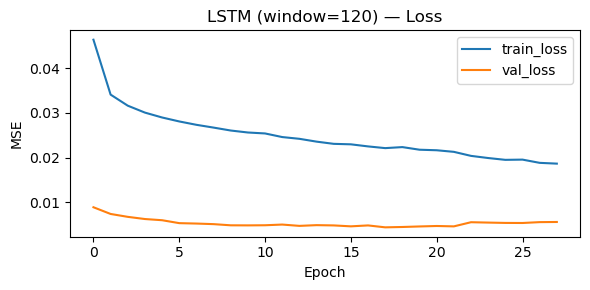

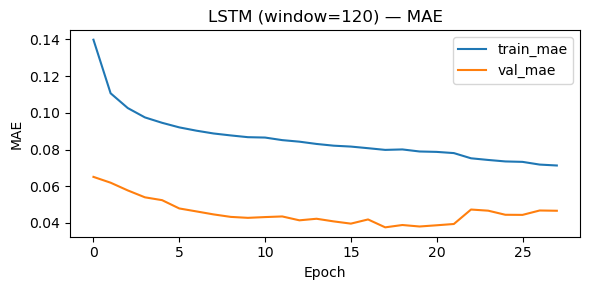

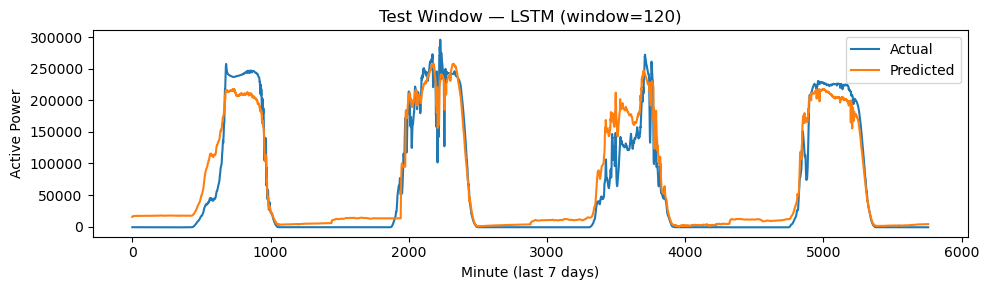

In [68]:

for W in WINDOW_SIZES:
    Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
    Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
    Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

    model = build_lstm((W, Xtr.shape[-1]))

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
    

    # visible progress (loss, mae, mape)
    history = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlrop],
        shuffle=False,           
    )

    y_pred = model.predict(Xte, verbose=0).ravel()
    mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

    results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

    # ---- Training curves ----
    plt.figure(figsize=(6,3))
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title(f"LSTM (window={W}) — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history["mae"], label="train_mae")
    plt.plot(history.history["val_mae"], label="val_mae")
    plt.title(f"LSTM (window={W}) — MAE")
    plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Test visualization ----
    steps = min(len(y_true_inv), 4*24*60)
    plt.figure(figsize=(10,3))
    plt.plot(y_true_inv[-steps:], label="Actual")
    plt.plot(y_pred_inv[-steps:], label="Predicted")
    plt.title(f"Test Window — LSTM (window={W})")
    plt.xlabel("Minute (last 7 days)")
    plt.ylabel("Active Power")
    plt.legend(); plt.tight_layout(); plt.show()

    model.save(f"LSTM_IG{W}.keras")  # save model


In [69]:
# ---- Print summary ----
for W, r in results.items():
    mae, rmse, r2 = r["metrics"]
    print(f"[LSTM window={W}]  MAE: {mae:,.0f}   RMSE: {rmse:,.0f}   R²: {r2:.3f}")

[LSTM window=30]  MAE: 21,988   RMSE: 31,477   R²: 0.909
[LSTM window=60]  MAE: 17,822   RMSE: 27,811   R²: 0.929
[LSTM window=120]  MAE: 14,234   RMSE: 24,201   R²: 0.946


/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


actual    predicted        error
Time                                                     
2020-10-19 21:12:00 -883.438599  1020.264526  1903.703125
2020-10-19 21:13:00 -876.516724  1054.170776  1930.687500
2020-10-19 21:14:00 -876.235474  1002.741089  1878.976562
2020-10-19 21:15:00 -886.118286  1005.944214  1892.062500
2020-10-19 21:16:00 -880.626099  1004.850464  1885.476562

MAE: 14,233.84 | RMSE: 24,201.40 | R²: 0.946


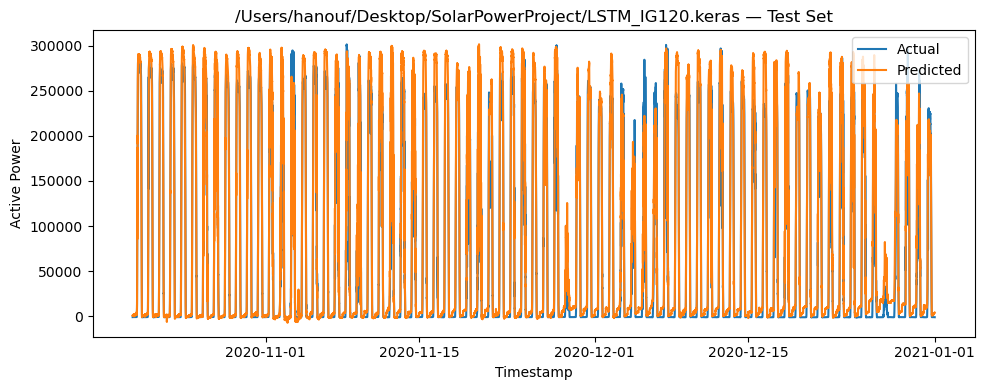

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

# pick the window/model you want to inspect
WINDOW = 120
MODEL_FILE = f"/Users/hanouf/Desktop/SolarPowerProject/LSTM_IG120.keras"  

model = keras.models.load_model(MODEL_FILE,compile=False)

# rebuild the test sequences
Xte, yte = make_sequences(X_test, y_test, window=WINDOW, horizon=HORIZON)
y_pred_sc = model.predict(Xte, verbose=0).ravel()

# bring predictions back to the original scale + compute metrics
mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred_sc)

# align predictions with their timestamps
len_test = len(X_test)
test_idx = y.index[-len_test:]
aligned_idx = test_idx[WINDOW + HORIZON - 1:]

comparison = (
    pd.DataFrame({"actual": y_true_inv, "predicted": y_pred_inv}, index=aligned_idx)
    .assign(error=lambda df: df["predicted"] - df["actual"])
)

display(comparison.head())
print(f"MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f}")

plt.figure(figsize=(10,4))
plt.plot(aligned_idx, y_true_inv, label="Actual")
plt.plot(aligned_idx, y_pred_inv, label="Predicted")
plt.title(f"{MODEL_FILE} — Test Set")
plt.xlabel("Timestamp")
plt.ylabel("Active Power")
plt.legend()
plt.tight_layout()
plt.show()


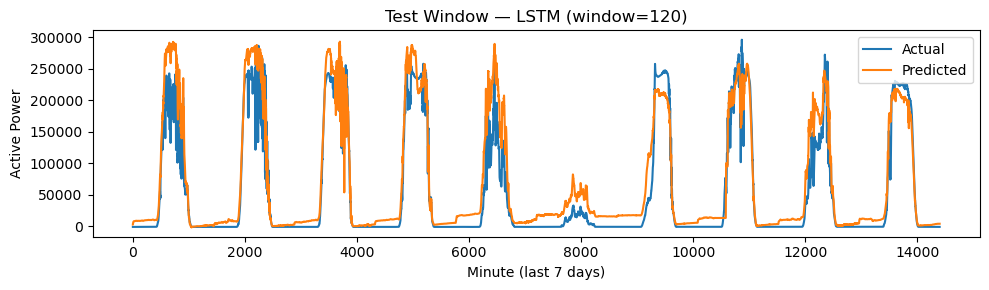

In [73]:
# ---- Test visualization ----
steps = min(len(y_true_inv), 10*24*60)
plt.figure(figsize=(10,3))
plt.plot(y_true_inv[-steps:], label="Actual")
plt.plot(y_pred_inv[-steps:], label="Predicted")
plt.title(f"Test Window — LSTM (window={W})")
plt.xlabel("Minute (last 7 days)")
plt.ylabel("Active Power")
plt.legend(); plt.tight_layout(); plt.show()

# Stacked LSTM

In [74]:
def build_Stackedlstm(input_shape):
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, dropout=0.01, recurrent_dropout=0.1),
        layers.LSTM(64, dropout=0.2, recurrent_dropout=0.1),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.AdamW(),
        loss="mse",
        metrics=['mae', 'mape'])
    
    return model

Epoch 1/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1069s 717ms/step - loss: 0.0739 - mae: 0.1774 - mape: 101.5267 - val_loss: 0.0120 - val_mae: 0.0693 - val_mape: 34.6053 - learning_rate: 0.0010
Epoch 2/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1042s 703ms/step - loss: 0.0520 - mae: 0.1307 - mape: 100.7741 - val_loss: 0.0090 - val_mae: 0.0545 - val_mape: 22.2974 - learning_rate: 0.0010
Epoch 3/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 823s 555ms/step - loss: 0.0455 - mae: 0.1160 - mape: 97.8633 - val_loss: 0.0089 - val_mae: 0.0573 - val_mape: 21.3840 - learning_rate: 0.0010
Epoch 4/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 861s 555ms/step - loss: 0.0441 - mae: 0.1118 - mape: 103.1395 - val_loss: 0.0075 - val_mae: 0.0493 - val_mape: 19.2947 - learning_rate: 0.0010
Epoch 5/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 878s 593ms/step - loss: 0.0431 - mae: 0.1097 - mape: 88.4349 - val_loss: 0.0082 - val_mae: 0.0512 - val_mape: 23.3094 - learning_rate: 0.0010
Epoch 6/200
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 1005s 678ms/step - loss: 0.

/opt/anaconda3/envs/solar/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


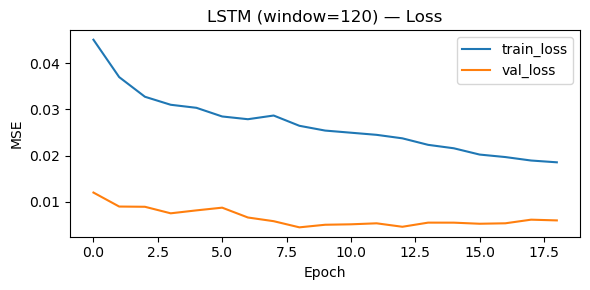

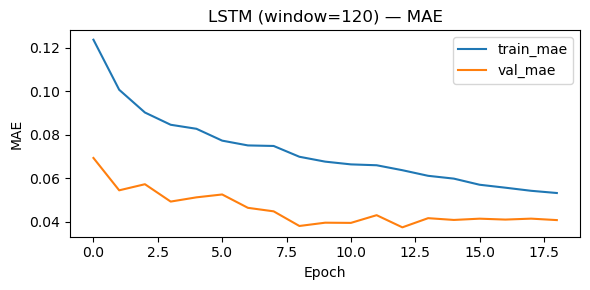

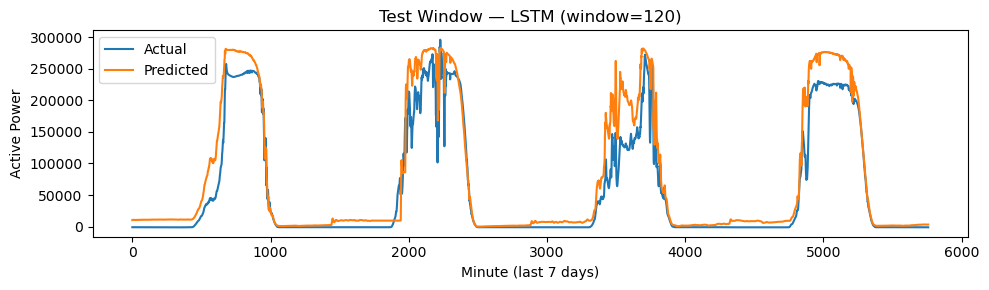

In [75]:

W=120  # choose window size from previous experiments
Xtr, ytr = make_sequences(X_train, y_train, window=W, horizon=HORIZON)
Xva, yva = make_sequences(X_val,   y_val,   window=W, horizon=HORIZON)
Xte, yte = make_sequences(X_test,  y_test,  window=W, horizon=HORIZON)

model = build_Stackedlstm((W, Xtr.shape[-1]))

es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)


# visible progress (loss, mae, mape)
history = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlrop],
    shuffle=False,           
)

y_pred = model.predict(Xte, verbose=0).ravel()
mae, rmse, r2, y_true_inv, y_pred_inv = inverse_metrics(yte, y_pred)

results[W] = {"history": history, "metrics": (mae, rmse, r2), "y_true": y_true_inv, "y_pred": y_pred_inv}

# ---- Training curves ----
plt.figure(figsize=(6,3))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title(f"LSTM (window={W}) — Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")
plt.title(f"LSTM (window={W}) — MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend(); plt.tight_layout(); plt.show()

# ---- Test visualization ----
steps = min(len(y_true_inv), 4*24*60)
plt.figure(figsize=(10,3))
plt.plot(y_true_inv[-steps:], label="Actual")
plt.plot(y_pred_inv[-steps:], label="Predicted")
plt.title(f"Test Window — LSTM (window={W})")
plt.xlabel("Minute (last 7 days)")
plt.ylabel("Active Power")
plt.legend(); plt.tight_layout(); plt.show()


model.save(f"StackedLSTM_IG{W}.keras")  # save model

